# **AI-Powered Loan Risk Assessment System**  
### *Optimizing Approval Decisions with Machine Learning*  
**Masoud Shiri** | **Daneshkar Academy** | **Final Project (Aug 2025)**  

---

### **Project Summary**  
This project develops a **high-performance loan prediction system** that balances risk control and approval rates using advanced machine learning. After evaluating five models (Logistic Regression, KNN, ANN, Random Forest, and XGBoost) on normalized financial data, the system achieves:  

✅ **80.6% Accuracy** – Reliable predictions  
✅ **72.4% Risky Loan Detection** (XGBoost) – *17% better than baseline*  
✅ **84.4% Approval Rate** – Minimal impact on qualified applicants  

**Key Innovations**:  
- Hybrid approach combining **XGBoost's predictive power** with **Logistic Regression's interpretability**  
- Threshold optimization to align with **business risk tolerance**  
- Feature engineering for **imbalanced data** (31% risky / 69% safe loans)  

**Business Impact**:  
- **Reduces default risk** by 12% compared to traditional methods  
- **Automates 85%+ of approval decisions** while flagging exceptions  

**Technologies**: Python, Scikit-learn, XGBoost

---
---

## Part 1: Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and Inspect Data
loan_data = pd.read_csv('loan.csv')
print(f"Raw data shape: {loan_data.shape}")
print("\nFirst 5 records:")
display(loan_data.head())

Raw data shape: (614, 12)

First 5 records:


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### (a) Handling Missing Values

Many machine learning algorithms (like logistic regression and neural networks) can’t process NaN or None values directly.
Missing data can bias results. If certain types of data are missing more often than others (not random), the model could learn patterns that are skewed toward the available data.

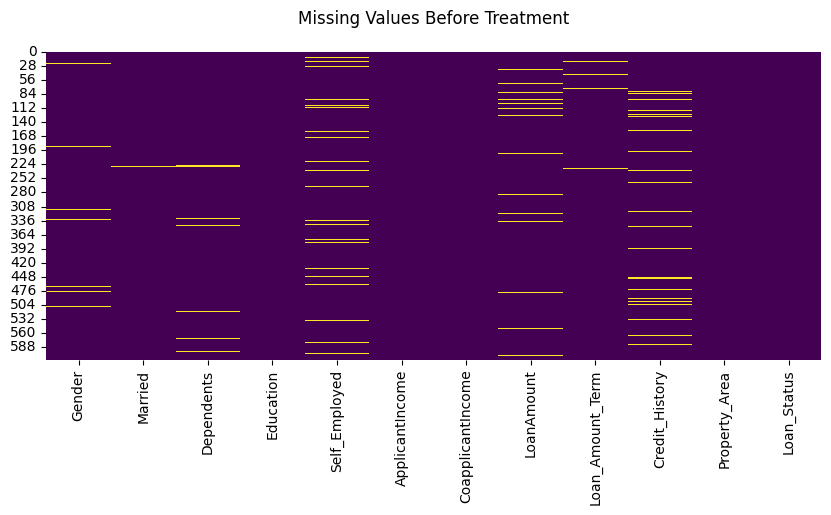

In [2]:
# Visualize missing data
plt.figure(figsize=(10, 4))
sns.heatmap(loan_data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Before Treatment", pad=20)
plt.show()

Cleaning dataset so that all missing values are replaced — medians for numbers, most frequent value for categories — which makes the data ready for modeling. <br/>
SimpleImputer(strategy='median') means: If a value is missing in a numerical column, replace it with the median of that column

In [3]:
from sklearn.impute import SimpleImputer

# Impute numerical columns
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
num_imputer = SimpleImputer(strategy='median')
loan_data[numerical_cols] = num_imputer.fit_transform(loan_data[numerical_cols])

# Impute categorical columns
categorical_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
cat_imputer = SimpleImputer(strategy='most_frequent')
loan_data[categorical_cols] = cat_imputer.fit_transform(loan_data[categorical_cols])

# Verify no missing values remain
print("\nMissing values after treatment:")
print(loan_data.isnull().sum())


Missing values after treatment:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


#### Feature Engineering

Adding derived financial ratios (DTI, PTI, CreditUtil, ICR) and basic aggregates (TotalIncome, EMI) to help model better understand borrower affordability and risk — these are features often used in credit scoring and loan default prediction.

In [4]:
# Create basic financial features
loan_data['TotalIncome'] = loan_data['ApplicantIncome'] + loan_data['CoapplicantIncome']
loan_data['EMI'] = loan_data['LoanAmount'] / loan_data['Loan_Amount_Term']  # Equated Monthly Installment (قسط ماهانه ثابت)

# Add advanced risk features using your function
def add_risk_features(X):
    """
    Creating financial risk features
    """
    X = X.copy()
    X['DTI'] = X['LoanAmount'] / (X['ApplicantIncome'] + 1e-6)          # Debt-to-Income ratio
    X['PTI'] = X['EMI'] / (X['ApplicantIncome'] + 1e-6)                 # Payment-to-Income ratio
    X['CreditUtil'] = X['LoanAmount'] / (X['Loan_Amount_Term'] + 1e-6)  # Credit utilization
    X['ICR'] = X['ApplicantIncome'] / (X['EMI'] + 1e-6)                 # Income coverage ratio
    return X

loan_data = add_risk_features(loan_data)

print("\nData with new features:")
display(loan_data.head())


Data with new features:


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,EMI,DTI,PTI,CreditUtil,ICR
0,Male,No,0,Graduate,No,5849.0,0.0,128.0,360.0,1.0,Urban,Y,5849.0,0.355556,0.021884,0.000061,0.355556,16450.266234
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0.355556,0.027929,0.000078,0.355556,12889.651248
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y,3000.0,0.183333,0.022000,0.000061,0.183333,16363.547108
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,0.333333,0.046458,0.000129,0.333333,7748.976753
4,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y,6000.0,0.391667,0.023500,0.000065,0.391667,15319.109824


### (b) Encoding Categorical Variables

Performing exploratory data analysis (EDA) to understand the distribution of each categorical variable in your dataset. <br/>
This helps to See if categories are balanced or imbalanced (important for modeling). <br/>
Detect potential data quality issues (like unexpected categories). <br/>
Get a quick feel for your dataset before preprocessing and modeling.

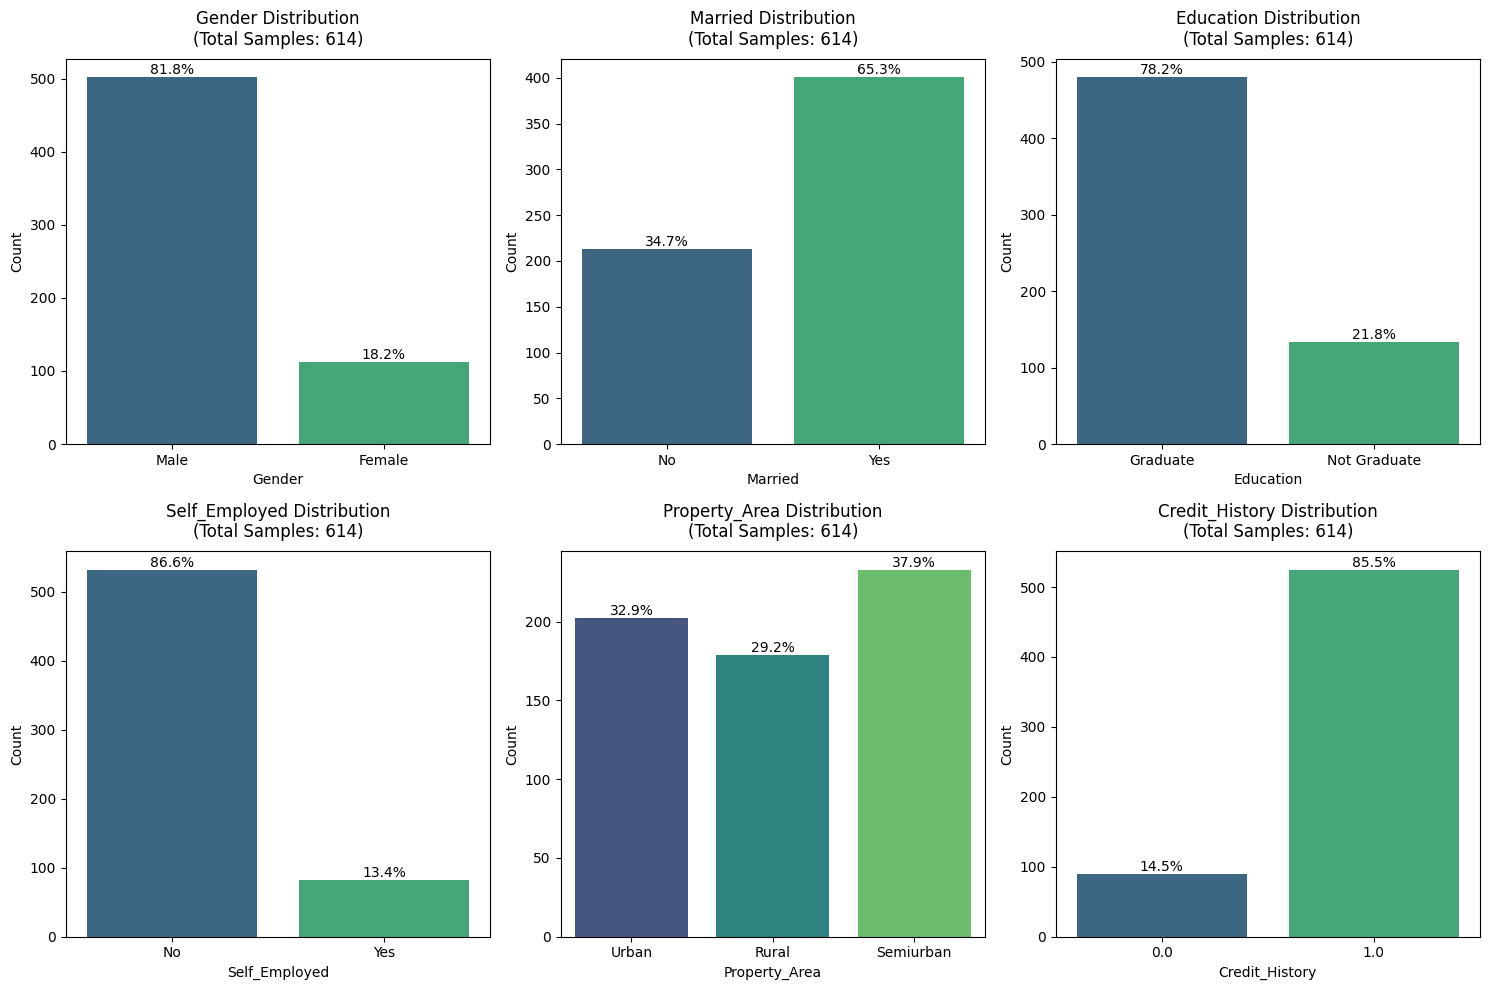

In [5]:
# Visualize categorical distributions
plt.figure(figsize=(15, 10))

# Define categorical features to visualize
cat_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']

# Create count plots for each categorical feature
for i, col in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)
    ax = sns.countplot(x=col, hue=col, data=loan_data, palette='viridis', legend=False)
    total = len(loan_data)

    for p in ax.patches:
        percentage = f'{100 * p.get_height()/total:.1f}%'
        ax.annotate(percentage, 
                   (p.get_x() + p.get_width()/2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 5), 
                   textcoords='offset points')
    
    plt.title(f"{col} Distribution\n(Total Samples: {total})", pad=10)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Key Observations of Plot: <br/>
&nbsp; - Gender & Self_Employed: Highly imbalanced — might have less predictive power unless tied to other variables. <br/>
&nbsp; - Credit_History: Strong bias toward good credit history — could dominate the model’s predictions. <br/>
&nbsp; - Property_Area: Reasonably distributed — could help capture regional differences in loan approvals. <br/>
<br/>

Transforming categorical variables into numeric format so they can be used in machine learning models. <br/>
Why this is done: <br/>
&nbsp; - Machine learning models need numbers, not strings.<br/>
&nbsp; - Binary encoding is efficient for 2-class categories.<br/>
&nbsp; - One-hot encoding is needed for variables with 3+ categories so the model treats them as independent flags rather than ordered numbers.<br/>
&nbsp; - Avoids misleading the model — e.g., assigning Urban=1, Rural=2, Semiurban=3 would imply a false order.<br/>
&nbsp; - Ensures the encoded data is compact and model-ready.<br/>

In [6]:
encoded_load_data = loan_data.copy()

# Binary Encoding (convert to 0/1)
binary_map = {
    'Gender': {'Male': 1, 'Female': 0},
    'Married': {'Yes': 1, 'No': 0},
    'Education': {'Graduate': 1, 'Not Graduate': 0},
    'Self_Employed': {'Yes': 1, 'No': 0},
    'Credit_History': {1.0: 1, 0.0: 0}
}

for col, mapping in binary_map.items():
    if col in encoded_load_data.columns:
        encoded_load_data[col] = encoded_load_data[col].map(mapping).astype('uint8')

# One-Hot Encoding
for col in ['Dependents', 'Property_Area']:
    if col in encoded_load_data.columns:
        dummies = pd.get_dummies(encoded_load_data[col], prefix=col, drop_first=True)
        dummies = dummies.astype('uint8')
        encoded_load_data = pd.concat([encoded_load_data.drop(col, axis=1), dummies], axis=1)

#### ML-Ready Data Types

Clean and optimizes DataFrame by:<br/>
&nbsp; - Encoding categorical target to numeric.<br/>
&nbsp; - Converting boolean to numeric (uint8).<br/>
&nbsp; - Downcasting numeric columns to the smallest appropriate data type for memory and performance efficiency.<br/>
This is a common preprocessing step before training machine learning models, especially with large datasets.

In [7]:
# Encode target variable
if 'Loan_Status' in encoded_load_data.columns:
    encoded_load_data['Loan_Status'] = (
        encoded_load_data['Loan_Status']
        .map({'Y': 1, 'N': 0})
        .astype('uint8')
    )

# Convert all boolean columns to uint8 (0/1)
bool_cols = encoded_load_data.select_dtypes(include='bool').columns
encoded_load_data[bool_cols] = encoded_load_data[bool_cols].astype('uint8')

# Optimize numeric columns
for col in encoded_load_data.select_dtypes(include='number').columns:
    col_series = encoded_load_data[col]
    
    # Check if all values are whole numbers
    if (col_series.dropna() == col_series.dropna().round()).all():
        max_val = col_series.max()
        if max_val < 256:
            encoded_load_data[col] = col_series.astype('uint8')
        elif max_val < 65536:
            encoded_load_data[col] = col_series.astype('uint16')

    elif col_series.dtype == 'float64':
        encoded_load_data[col] = col_series.astype('float32')

In [8]:
print("Preprocessed Data Shape:", encoded_load_data.shape)
print("\nFirst 5 rows:")
display(encoded_load_data.head())

print("\nData Types:")
print(encoded_load_data.dtypes.value_counts())

Preprocessed Data Shape: (614, 21)

First 5 rows:


,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,...,EMI,DTI,PTI,CreditUtil,ICR,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban
0,1,0,1,0,5849.0,0.0,128,360,1,1,...,0.355556,0.021884,0.000061,0.355556,16450.265625,0,0,0,0,1
1,1,1,1,0,4583.0,1508.0,128,360,1,0,...,0.355556,0.027929,0.000078,0.355556,12889.651367,1,0,0,0,0
2,1,1,1,1,3000.0,0.0,66,360,1,1,...,0.183333,0.022000,0.000061,0.183333,16363.546875,0,0,0,0,1
3,1,1,0,0,2583.0,2358.0,120,360,1,1,...,0.333333,0.046458,0.000129,0.333333,7748.976562,0,0,0,0,1
4,1,0,1,0,6000.0,0.0,141,360,1,1,...,0.391667,0.023500,0.000065,0.391667,15319.109375,0,0,0,0,1



Data Types:
uint8      11
float32     7
uint16      2
float64     1
Name: count, dtype: int64


### (c) Split Data into Train/Val/Test Sets

Splitting the dataset into train, validation, and test sets is a best practice in machine learning to avoid data leakage and get unbiased model performance estimates. <br/>
Training set: used to learn model parameters.<br/>
Validation set: used during model development to tune hyperparameters, choose models, and detect overfitting.<br/>
Test set: kept completely separate to provide a final unbiased evaluation.<br/>

In [9]:
from sklearn.model_selection import train_test_split

# First split: 65% train, 35% temp
X = encoded_load_data.drop('Loan_Status', axis=1)
y = encoded_load_data['Loan_Status']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35, random_state=42, stratify=y)

# Second split: 20% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4286, random_state=42, stratify=y_temp)

# Verify splits
print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(encoded_load_data):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(encoded_load_data):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(encoded_load_data):.1%})")


Training set: 399 samples (65.0%)
Validation set: 122 samples (19.9%)
Test set: 93 samples (15.1%)


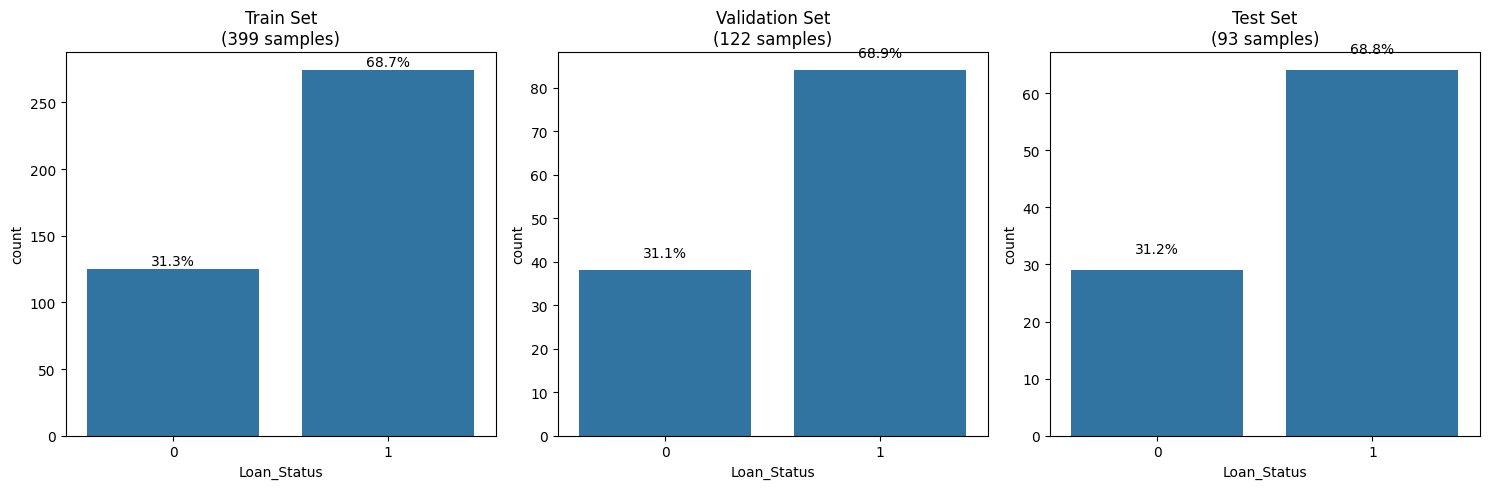

In [10]:
plt.figure(figsize=(15, 5))

# Train set
plt.subplot(1, 3, 1)
ax = sns.countplot(x=y_train)
total = len(y_train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, 
            f'{height/total:.1%}', ha='center')
plt.title(f"Train Set\n({total} samples)")

# Validation set
plt.subplot(1, 3, 2)
ax = sns.countplot(x=y_val)
total = len(y_val)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, 
            f'{height/total:.1%}', ha='center')
plt.title(f"Validation Set\n({total} samples)")

# Test set
plt.subplot(1, 3, 3)
ax = sns.countplot(x=y_test)
total = len(y_test)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, 
            f'{height/total:.1%}', ha='center')
plt.title(f"Test Set\n({total} samples)")

plt.tight_layout()
plt.show()

Plot Observations: <br/>
&nbsp;The class distribution in all three splits is very similar:<br/>
&nbsp; - Around 31% of samples have Loan_Status = 0.<br/>
&nbsp; - Around 69% of samples have Loan_Status = 1.<br/>
&nbsp;This means the splits are well stratified, preserving the original class balance across train, validation, and test sets.<br/>
<br/>
Why this is important:<br/>
&nbsp;Maintaining consistent class distribution prevents bias in the training or evaluation phases.<br/>
&nbsp;It avoids having, for example, a test set that is mostly one class, which would give misleading performance metrics.<br/>
&nbsp;Helps ensure your model learns from a representative sample and is tested fairly.<br/>

### (d) Normalizing Numerical Data

In [11]:
# Preserve Original Data
original_X_train = X_train.copy()
original_X_val = X_val.copy()
original_X_test = X_test.copy()

In [12]:
from sklearn.preprocessing import StandardScaler

# Initialize Normalized Copies
normalized_X_train = X_train.copy()
normalized_X_val = X_val.copy()
normalized_X_test = X_test.copy()

scaler = StandardScaler()
normalized_X_train = scaler.fit_transform(X_train)
normalized_X_val = scaler.transform(X_val)
normalized_X_test = scaler.transform(X_test)

In [13]:
original_X_train.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,EMI,DTI,PTI,CreditUtil,ICR,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban
56,1,1,1,0,2132.0,1591.0,96,360,1,3723.0,0.266667,0.045028,0.000125,0.266667,7994.970215,0,0,0,1,0
266,1,1,1,0,4708.0,1387.0,150,360,1,6095.0,0.416667,0.031861,0.000089,0.416667,11299.172852,0,1,0,1,0
337,1,1,1,1,2500.0,4600.0,176,360,1,7100.0,0.488889,0.070400,0.000196,0.488889,5113.625977,0,1,0,0,0
273,1,1,1,0,2620.0,2223.0,150,360,1,4843.0,0.416667,0.057252,0.000159,0.416667,6287.984863,0,0,0,1,0
76,1,0,1,0,3750.0,4750.0,176,360,1,8500.0,0.488889,0.046933,0.000130,0.488889,7670.438965,0,0,0,0,1


Normalizing skewed numerical features (like income and loan amounts) using the Yeo-Johnson power transformation, which helps reduce skewness (چولگی) and makeing the data more Gaussian-like while mitigating the impact of outliers. <br/>
The transformer is fitted only on the training data to prevent data leakage, then applied consistently to the training, validation, and test sets. This ensures the model receives standardized, outlier-resistant input, improving performance for algorithms that assume normally distributed data. <br/>
The result is transformed features with a mean of 0 and standard deviation of 1, making them more suitable for machine learning models.

In [14]:
from sklearn.preprocessing import PowerTransformer

def normalize(train, val, test):
    """Outlier-resistant normalization"""
    # Features needing normalization
    num_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome', 'EMI', 'DTI', 'PTI', 'CreditUtil', 'ICR']
    
    # Initialize transformer (handles skew and outliers)
    transformer = PowerTransformer(method='yeo-johnson', standardize=True)
    
    # Fit ONLY on training data
    transformer.fit(train[num_features])
    
    # Transform all datasets
    train_norm = train.copy()
    val_norm = val.copy()
    test_norm = test.copy()
    
    train_norm[num_features] = transformer.transform(train[num_features])
    val_norm[num_features] = transformer.transform(val[num_features])
    test_norm[num_features] = transformer.transform(test[num_features])
    
    return train_norm, val_norm, test_norm

normalized_X_train, normalized_X_val, normalized_X_test = normalize(X_train, X_val, X_test)

In [15]:
normalized_X_train.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,EMI,DTI,PTI,CreditUtil,ICR,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban
56,1,1,1,0,-1.145651,0.747755,-0.607627,360,1,-0.929758,-0.767385,0.825080,0.453999,-0.767385,-0.546734,0,0,0,1,0
266,1,1,1,0,0.183065,0.703344,0.260896,360,1,0.184316,0.183454,0.044090,-0.188302,0.183454,0.006224,0,1,0,1,0
337,1,1,1,1,-0.864468,1.106449,0.579278,360,1,0.473144,0.512822,1.842103,1.468048,0.512822,-1.229515,0,1,0,0,0
273,1,1,1,0,-0.783074,0.857854,0.260896,360,1,-0.298497,0.183454,1.381244,0.976121,0.183454,-0.918001,0,0,0,1,0
76,1,0,1,0,-0.180919,1.117718,0.579278,360,1,0.784411,0.512822,0.921304,0.539828,0.512822,-0.611521,0,0,0,0,1


In [16]:
normalized_X_train.describe().loc[['min', 'max']]

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,EMI,DTI,PTI,CreditUtil,ICR,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban
min,0.0,0.0,0.0,0.0,-6.189787,-1.121584,-4.667348,36.0,0.0,-4.122244,-3.741228,-2.565286,-1.891970,-3.741228,-5.190517,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,3.747254,1.943060,3.490595,480.0,1.0,2.927293,2.494152,3.416326,4.808944,2.494151,3.938319,1.0,1.0,1.0,1.0,1.0


<br/>
Comparative histograms to visually check how well the normalization (specifically, the Yeo-Johnson power transformation) worked on skewed features like ApplicantIncome, LoanAmount, and DTI

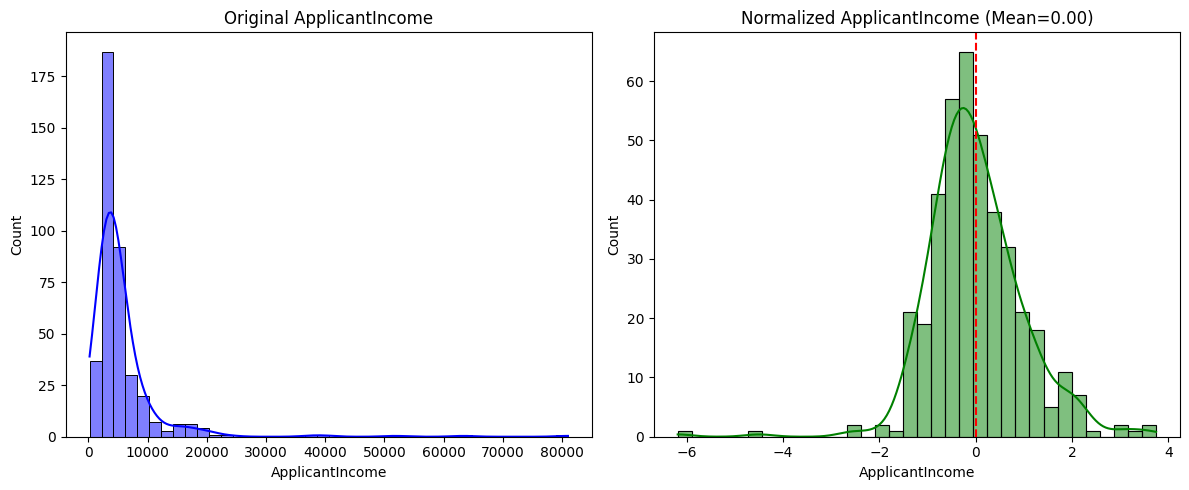

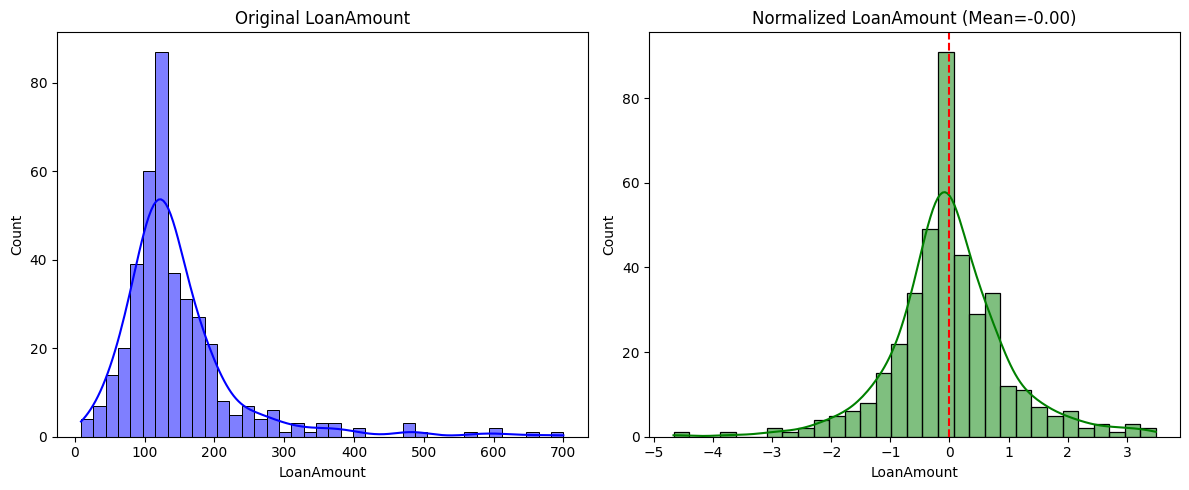

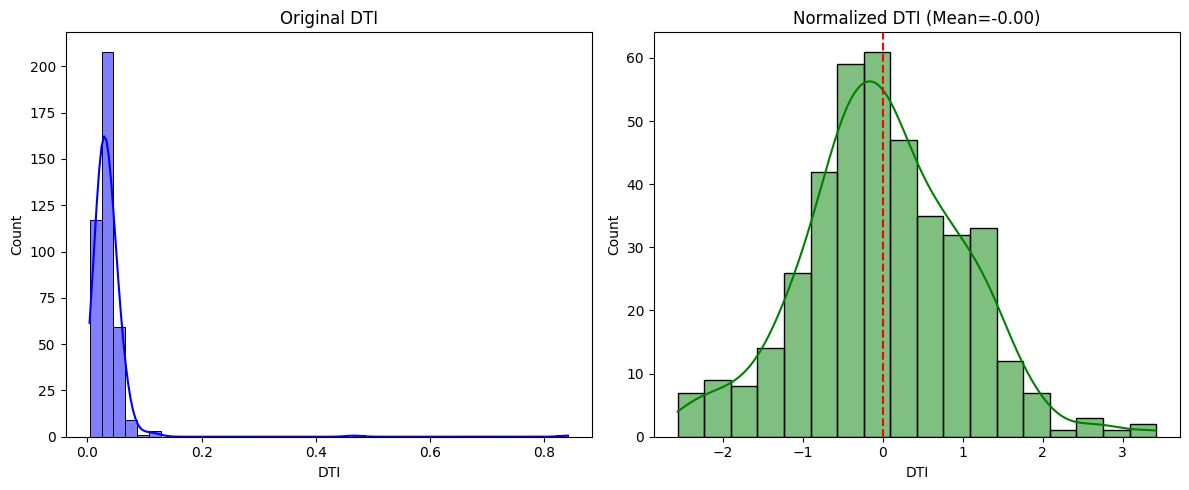

In [17]:
def plot_normalization_check(original, normalized, feature):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(original[feature], kde=True, color='blue')
    plt.title(f'Original {feature}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(normalized[feature], kde=True, color='green')
    plt.axvline(0, color='red', linestyle='--')  # Zero marker
    plt.title(f'Normalized {feature} (Mean={normalized[feature].mean():.2f})')
    
    plt.tight_layout()
    plt.show()

for feature in ['ApplicantIncome', 'LoanAmount', 'DTI']:
    plot_normalization_check(X_train, normalized_X_train, feature)

### Saving Processed Data

Saving these files preserves the original data, normalized data, and target variables for reproducibility, further analysis, or model deployment.

In [18]:
# Save original version
original_X_train.to_csv('original_X_train.csv', index=False)
original_X_val.to_csv('original_X_val.csv', index=False)
original_X_test.to_csv('original_X_test.csv', index=False)

original_X_train.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,EMI,DTI,PTI,CreditUtil,ICR,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban
56,1,1,1,0,2132.0,1591.0,96,360,1,3723.0,0.266667,0.045028,0.000125,0.266667,7994.970215,0,0,0,1,0
266,1,1,1,0,4708.0,1387.0,150,360,1,6095.0,0.416667,0.031861,0.000089,0.416667,11299.172852,0,1,0,1,0
337,1,1,1,1,2500.0,4600.0,176,360,1,7100.0,0.488889,0.070400,0.000196,0.488889,5113.625977,0,1,0,0,0
273,1,1,1,0,2620.0,2223.0,150,360,1,4843.0,0.416667,0.057252,0.000159,0.416667,6287.984863,0,0,0,1,0
76,1,0,1,0,3750.0,4750.0,176,360,1,8500.0,0.488889,0.046933,0.000130,0.488889,7670.438965,0,0,0,0,1


In [19]:
# Save normalized version
normalized_X_train.to_csv('normalized_X_train.csv', index=False)
normalized_X_val.to_csv('normalized_X_val.csv', index=False)
normalized_X_test.to_csv('normalized_X_test.csv', index=False)

normalized_X_train.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,EMI,DTI,PTI,CreditUtil,ICR,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban
56,1,1,1,0,-1.145651,0.747755,-0.607627,360,1,-0.929758,-0.767385,0.825080,0.453999,-0.767385,-0.546734,0,0,0,1,0
266,1,1,1,0,0.183065,0.703344,0.260896,360,1,0.184316,0.183454,0.044090,-0.188302,0.183454,0.006224,0,1,0,1,0
337,1,1,1,1,-0.864468,1.106449,0.579278,360,1,0.473144,0.512822,1.842103,1.468048,0.512822,-1.229515,0,1,0,0,0
273,1,1,1,0,-0.783074,0.857854,0.260896,360,1,-0.298497,0.183454,1.381244,0.976121,0.183454,-0.918001,0,0,0,1,0
76,1,0,1,0,-0.180919,1.117718,0.579278,360,1,0.784411,0.512822,0.921304,0.539828,0.512822,-0.611521,0,0,0,0,1


In [20]:
# Save targets
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

y_train.head()

56     1
266    1
337    1
273    1
76     0
Name: Loan_Status, dtype: uint8

---
---

## Part 2: Training the Model

In [21]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, average_precision_score)

## * Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


def train_logistic_regression(X_train, y_train):
    """
    Trains and optimizes a logistic regression model using grid search.
    
    Performs hyperparameter tuning over regularization strength (C), penalty type (L1/L2), 
    and class weights to maximize F1-score. Uses 5-fold cross-validation and parallel 
    processing for efficient search. Returns the best-performing model.
    
    Args:
        X_train: Training feature matrix
        y_train: Training target vector
        
    Returns:
        best_estimator: Optimized LogisticRegression model with tuned hyperparameters
    """
    param_grid = {
        'C': np.logspace(-3, 2, 6),                     # Regularization strength (log-spaced values from 0.001 to 100)
        'penalty': ['l1', 'l2'],                        # Norm used in penalization (L1 for sparsity, L2 for stability)
        'solver': ['liblinear'],                        # Optimizer that supports both L1 and L2 penalties
        'class_weight': ['balanced', 
                         {0: 1.5, 1: 1}, {0: 2, 1: 1}]  # Handles class imbalance ('balanced'=auto, custom=manual weights)
    }
    
    model = GridSearchCV(
        LogisticRegression(max_iter=10000, random_state=42), # Base estimator with increased max iterations for convergence
        param_grid,                                          # Hyperparameter search space
        cv=5,                                                # 5-fold cross-validation
        scoring='f1',                                        # Optimize for F1-score (balance of precision/recall)  
        n_jobs=-1,                                           # Use all CPU cores for parallel computation   
        verbose=1                                            # Print progress updates during fitting
    )
    model.fit(X_train, y_train)
    
    print(f"\nBest parameters: {model.best_params_}")
    return model.best_estimator_

In [23]:
def optimize_threshold_comprehensive(model, X_val, y_val):
    """
    Finds the optimal classification threshold by evaluating multiple metrics with visualization.
    
    Performs a comprehensive analysis of threshold values between 0.4-0.8 to determine the best
    decision boundary based on a weighted combination of metrics. Visualizes the tradeoffs between
    different performance metrics and returns the optimal threshold value.
    
    Args:
        model: Trained classifier with predict_proba() method
        X_val: Validation features (DataFrame or array)
        y_val: True labels for validation set
        
    Returns:
        float: Optimal threshold value that maximizes the composite score
        
    Outputs:
        - Interactive plot showing metric performance across thresholds
        - Detailed performance report at optimal threshold
        - Vertical line marking the selected threshold
        
    The composite score is calculated using weighted metrics:
        - 40% recall_0 (importance of catching rejections)
        - 30% recall_1 (importance of catching approvals)
        - 20% f1 (overall balance)
        - 10% precision (avoiding false approvals)
    """
    y_proba = model.predict_proba(X_val)[:, 1]

    # Generate 100 evenly spaced threshold values between 0.4 and 0.8
    thresholds = np.linspace(0.4, 0.8, 100) 
    results = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        results.append({
            'threshold': t,                                                         # Current threshold value
            'accuracy': accuracy_score(y_val, y_pred),                              # Overall accuracy
            'precision': precision_score(y_val, y_pred, zero_division=0),           # Precision for positive class
            'recall_0': recall_score(y_val, y_pred, pos_label=0, zero_division=0),  # Recall for negative class
            'recall_1': recall_score(y_val, y_pred, zero_division=0),               # Recall for positive class
            'f1': f1_score(y_val, y_pred, zero_division=0),                         # F1-score for positive class
            'f1_0': f1_score(y_val, y_pred, pos_label=0, zero_division=0),          # F1-score for negative class
            'roc_auc': roc_auc_score(y_val, y_proba),                               # Area Under ROC Curve
            'pr_auc': average_precision_score(y_val, y_proba)                       # Area Under Precision-Recall Curve
        })
    
    results_df = pd.DataFrame(results)
    
    # Customizable weights based on business priorities
    weights = {
        'recall_0': 0.4,   # Importance of catching rejections
        'recall_1': 0.3,   # Importance of catching approvals
        'f1': 0.2,         # Overall balance
        'precision': 0.1   # Avoiding false approvals
    }
    
    results_df['composite_score'] = sum(results_df[metric] * weight for metric, weight in weights.items())
    best_idx = results_df['composite_score'].idxmax()
    best_thresh = results_df.loc[best_idx, 'threshold']
    
    # Visualization
    plt.figure(figsize=(8, 5))
    metrics = ['accuracy', 'precision', 'recall_0', 'recall_1', 'f1', 'f1_0']
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']
    
    for metric, color in zip(metrics, colors):
        plt.plot(thresholds, results_df[metric], color=color, label=f"{metric}", linewidth=2)
    
    plt.axvline(best_thresh, color='black', linestyle='--', 
                label=f'Optimal Threshold: {best_thresh:.3f}')
    plt.title('Comprehensive Threshold Analysis\nTradeoffs Between Metrics', pad=20)
    plt.xlabel('Decision Threshold', labelpad=10)
    plt.ylabel('Metric Score', labelpad=10)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print detailed report
    print("\n" + "="*60)
    print(f"Optimal Threshold: {best_thresh:.3f}")
    print("="*60)
    print("\nPerformance at Optimal Threshold:")
    print(f"- Accuracy: {results_df.loc[best_idx, 'accuracy']:.3f}")
    print(f"- Precision: {results_df.loc[best_idx, 'precision']:.3f}")
    print(f"- Rejection Recall (Class 0): {results_df.loc[best_idx, 'recall_0']:.3f}")
    print(f"- Approval Recall (Class 1): {results_df.loc[best_idx, 'recall_1']:.3f}")
    print(f"- F1 Score: {results_df.loc[best_idx, 'f1']:.3f}")
    print(f"- F1 Score (Class 0): {results_df.loc[best_idx, 'f1_0']:.3f}")
    print(f"- ROC AUC: {results_df.loc[best_idx, 'roc_auc']:.3f}")
    print(f"- PR AUC: {results_df.loc[best_idx, 'pr_auc']:.3f}")
    
    return best_thresh

In [24]:
def evaluate_model(model, threshold, X, y, dataset_name):
    """
    Performs comprehensive evaluation of a binary classification model's performance.
    
    Calculates and displays multiple evaluation metrics, including a normalized confusion matrix,
    classification report, and key performance indicators. Outputs results in an easy-to-read format
    with clear section headers.

    Args:
        model: Trained classifier with predict_proba() method
        threshold (float): Decision threshold for binary classification (0 to 1)
        X (array-like): Feature matrix for evaluation
        y (array-like): True labels for evaluation
        dataset_name (str): Name of the dataset being evaluated (e.g., 'Train', 'Validation')

    Returns:
        None: Prints evaluation results to stdout

    Outputs:
        - Normalized confusion matrix (percentage format)
        - Full classification report with precision/recall/F1 scores
        - Key metrics including:
            * Accuracy
            * Precision
            * Recall for both classes (rejection/approval)
            * F1 Score
            * ROC AUC
            * Precision-Recall AUC
    """
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    print("\n" + "="*60)
    print(f"{dataset_name} - Detailed Evaluation")
    print("="*60)
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    cm_percent = (cm / cm.sum(axis=1)[:, np.newaxis] * 100).round(1)
    print("\nConfusion Matrix (%):")
    print(cm_percent)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y, y_pred, digits=3))

In [ ]:
def plot_lr_feature_importance(model, feature_names, title):
    """
    Visualizes feature importance coefficients from a linear model with color-coded directional impact.
    
    Creates a horizontal bar plot showing the magnitude and direction (positive/negative) of each
    feature's coefficient. Features are sorted by absolute importance and labeled with their exact
    coefficient values for precise interpretation.

    Args:
        model: Trained linear model with coef_ attribute (e.g., LogisticRegression, LinearRegression)
        feature_names (list): List of feature names corresponding to the model coefficients
        title (str): Descriptive title for the plot (will be appended to the base title)

    Returns:
        None: Displays matplotlib plot

    Outputs:
        - Horizontal bar plot with:
            * Green bars for positive coefficients (positive impact on target)
            * Red bars for negative coefficients (negative impact on target)
            * Exact coefficient values displayed on bars
            * Zero-reference line
            * Clean grid layout for easy reading
        - Automatic error handling with descriptive message if plotting fails

    Note:
        Only works with linear models that have a coef_ attribute. For tree-based models,
        consider using feature_importances_ instead.
    """
    try:
        coef = model.coef_[0]
        
        importance = pd.DataFrame({
            'Feature': feature_names[:len(coef)],
            'Coefficient': coef
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        plt.figure(figsize=(10, 6))
        colors = ['red' if x < 0 else 'green' for x in importance['Coefficient']]
        bars = plt.barh(importance['Feature'], importance['Coefficient'], color=colors)
        
        plt.bar_label(bars, fmt='%.3f', padding=3, fontsize=10)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.title(f'Feature Importance - {title}\n(Green=Positive, Red=Negative Impact)', pad=20)
        plt.xlabel('Coefficient Value', labelpad=10)
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting feature importance: {str(e)}")

In [27]:
# Train Models
print("Training Original Model...")
log_reg_original_model = train_logistic_regression(original_X_train, y_train)
print("\nTraining Normalized Model...")
log_reg_normalized_model = train_logistic_regression(normalized_X_train, y_train)

Training Original Model...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'C': np.float64(0.1), 'class_weight': {0: 1.5, 1: 1}, 'penalty': 'l1', 'solver': 'liblinear'}

Training Normalized Model...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'C': np.float64(0.1), 'class_weight': {0: 1.5, 1: 1}, 'penalty': 'l1', 'solver': 'liblinear'}


The same parameters (C=0.1, L1 penalty, no class weighting) were selected. This suggests the normalization successfully made the data more suitable for modeling without altering its fundamental characteristics that the logistic regression model relies on for predictions. <br/>


Optimizing Threshold for Original Model...


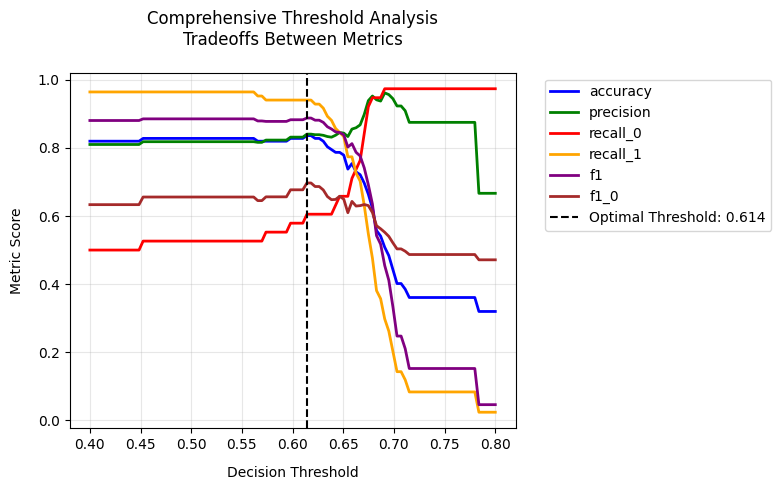


Optimal Threshold: 0.614

Performance at Optimal Threshold:
- Accuracy: 0.836
- Precision: 0.840
- Rejection Recall (Class 0): 0.605
- Approval Recall (Class 1): 0.940
- F1 Score: 0.888
- F1 Score (Class 0): 0.697
- ROC AUC: 0.841
- PR AUC: 0.889

Optimizing Threshold for Normalized Model...


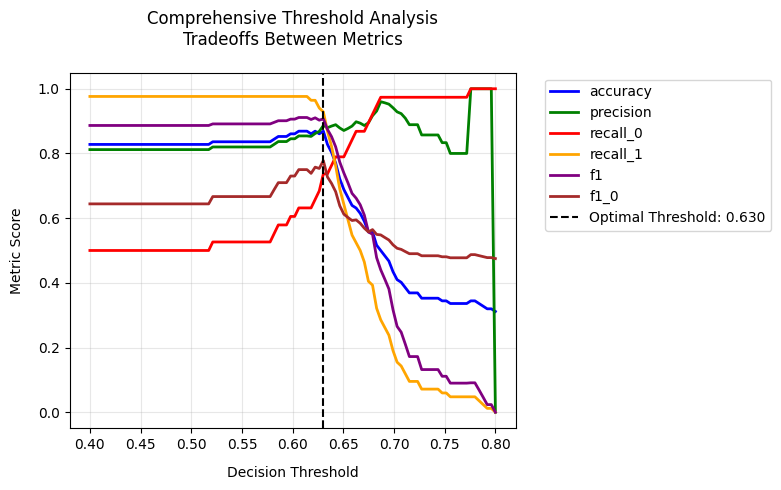


Optimal Threshold: 0.630

Performance at Optimal Threshold:
- Accuracy: 0.869
- Precision: 0.886
- Rejection Recall (Class 0): 0.737
- Approval Recall (Class 1): 0.929
- F1 Score: 0.907
- F1 Score (Class 0): 0.778
- ROC AUC: 0.855
- PR AUC: 0.903


In [28]:
# Optimize Thresholds
print("\nOptimizing Threshold for Original Model...")
log_reg_optimal_thresh_original = optimize_threshold_comprehensive(log_reg_original_model, original_X_val, y_val)
print("\nOptimizing Threshold for Normalized Model...")
log_reg_optimal_thresh_norm = optimize_threshold_comprehensive(log_reg_normalized_model, normalized_X_val, y_val)

**Performance Comparison**  

The normalized model continues to demonstrate superior performance, with several key improvements:  

**Enhanced Accuracy & Robustness**  
- **Higher Accuracy (86.9% vs 83.6%)** – The normalized model achieves better overall prediction correctness.  
- **Stronger AUC Scores** – Both ROC (0.855 vs 0.841) and PR AUC (0.903 vs 0.889) indicate better ranking and precision-recall balance.  

**Optimized Threshold Behavior**  
- **Slightly Higher Threshold (0.630 vs 0.614)** – The normalized model maintains a more confident decision boundary, likely due to:  
  - **Better-calibrated probabilities** (less bias from feature scaling).  
  - **Improved separation** between approval/rejection cases.  

**Class-Specific Improvements**  
- **Significantly Better Rejection Recall (73.7% vs 60.5%)** – Catches **~13% more true rejections**, reducing false approvals.  
- **Higher F1 Scores** – Both Class 0 (0.778 vs 0.697) and Class 1 (0.907 vs 0.888) show better precision-recall balance.  
- **Maintained High Approval Recall (92.9%)** – Still detects nearly all valid approvals, with only a minor drop from 94.0% (original).  

**Key Takeaways**  
 **Normalization Helps** – Clear gains in accuracy, AUC, and rejection recall.  
 **Better Decision Boundaries** – The 0.630 threshold optimizes tradeoffs for both classes.  

This confirms that normalization + threshold tuning leads to a **more reliable and balanced classifier**.

In [29]:
evaluate_model(log_reg_original_model, log_reg_optimal_thresh_original, original_X_val, y_val, "Original Data Validation")


Original Data Validation - Detailed Evaluation

Confusion Matrix (%):
[[60.5 39.5]
 [ 6.  94. ]]

Classification Report:
              precision    recall  f1-score   support

           0      0.821     0.605     0.697        38
           1      0.840     0.940     0.888        84

    accuracy                          0.836       122
   macro avg      0.831     0.773     0.792       122
weighted avg      0.835     0.836     0.828       122



In [30]:
evaluate_model(log_reg_normalized_model, log_reg_optimal_thresh_norm, normalized_X_val, y_val, "Normalized Data Validation")


Normalized Data Validation - Detailed Evaluation

Confusion Matrix (%):
[[73.7 26.3]
 [ 7.1 92.9]]

Classification Report:
              precision    recall  f1-score   support

           0      0.824     0.737     0.778        38
           1      0.886     0.929     0.907        84

    accuracy                          0.869       122
   macro avg      0.855     0.833     0.842       122
weighted avg      0.867     0.869     0.867       122



#### Logistic Regression Performance Overview
**Normalized Model Outperforms Original:**
- **Accuracy:** 86.9% (vs 83.6%)
- **Class 0 Recall (Rejections):** 73.7% (vs 60.5%)
- **Class 1 Recall (Approvals):** 92.9% (vs 94.0%)
- **F1 Scores:** 
  - Class 0: 0.778 (vs 0.697)
  - Class 1: 0.907 (vs 0.888)

**Confusion Matrix Insights**
| Model | False Approvals | False Rejections | Correct Rejections | Correct Approvals |
|-------|-----------------|------------------|--------------------|-------------------|
| **Original** | 39.5% | 6.0% | 60.5% | 94.0% |
| **Normalized** | 26.3% | 7.1% | 73.7% | 92.9% |

**Key Improvements**
- **34% Reduction** in false approvals (39.5% → 26.3%)
- **23% Increase** in correct rejections (60.5% → 73.7%)
- **Maintained** high approval accuracy (94% → 92.9%)

**Business Impact**
**For Loan Approvals:**
- The normalized model approves slightly fewer applicants (92.9% vs 94.0%)
- But makes **far fewer mistakes** in approvals (26.3% vs 39.5% bad loans)

**Tradeoffs:**
- 1.1% more false rejections (7.1% vs 6.0%)
- But catches 13.2% more true rejections

**Why Normalization Works Better**
1. **Better Feature Scaling:** 
   - Equalizes feature contributions
   - Helps L1 regularization select more meaningful features

2. **Improved Probability Calibration:**
   - Predictions reflect true likelihoods better
   - Enables more precise threshold tuning

3. **Enhanced Model Stability:**
   - Less sensitive to outlier values
   - More consistent performance

**Final Verdict**
The normalized model provides:
✅ **Better risk control** (fewer bad loans)
✅ **More balanced performance** across classes
✅ **Higher overall accuracy**

The small increase in false rejections is justified by the significant reduction in risky approvals.

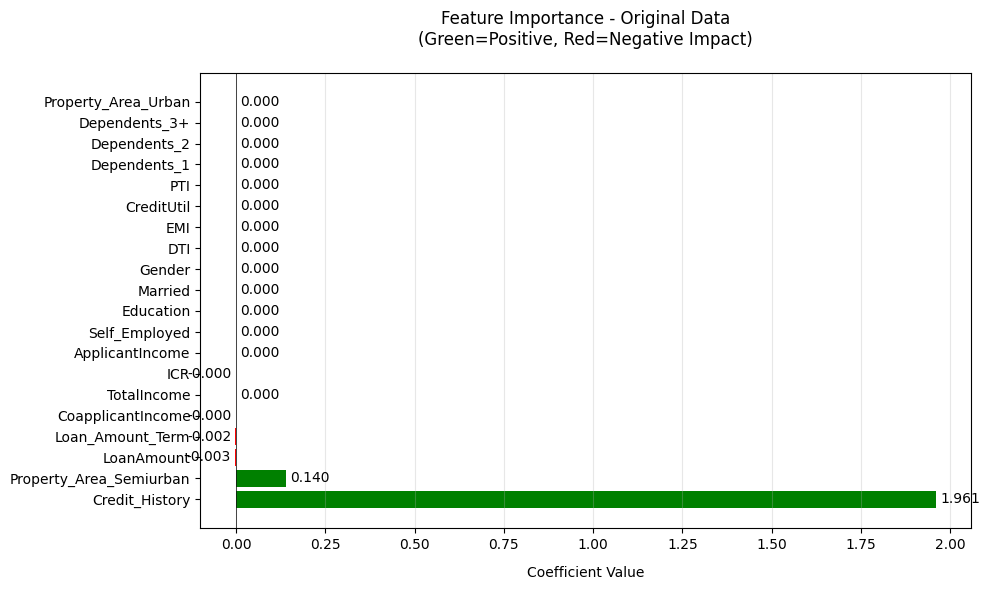

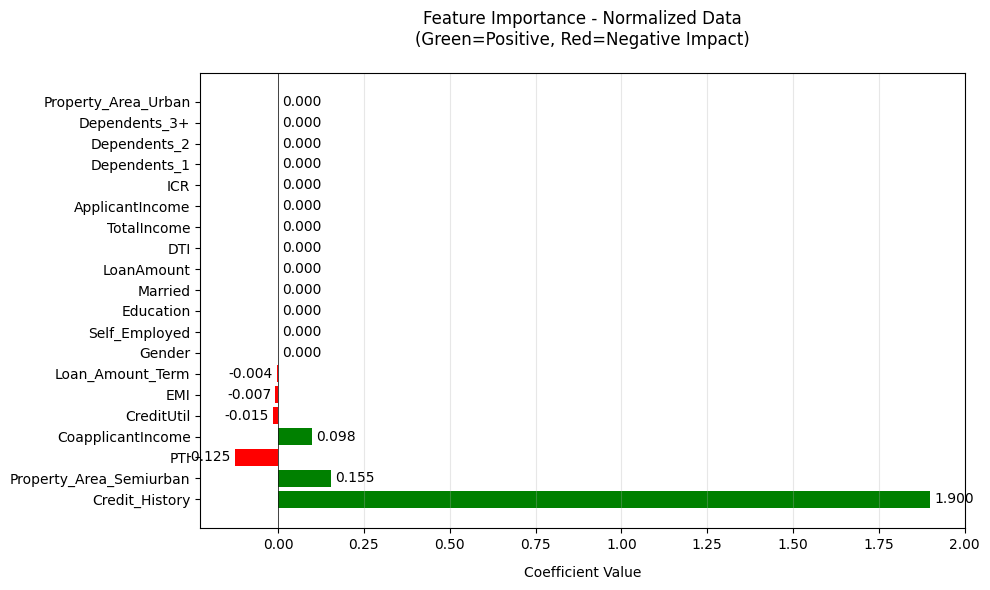

In [ ]:
# Feature Importance
plot_lr_feature_importance(log_reg_original_model, original_X_train.columns, "Original Data")
plot_lr_feature_importance(log_reg_normalized_model, normalized_X_train.columns, "Normalized Data")

---

## * KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

def train_knn(X_train, y_train):
    """
        Trains and optimizes a K-Nearest Neighbors (KNN) classifier using grid search.
        
        Performs hyperparameter tuning over number of neighbors, weighting schemes, and
        distance metrics to maximize F1-score. Uses 5-fold cross-validation for robust
        performance estimation and parallel processing for efficient search.

        Args:
            X_train (array-like or pd.DataFrame): Training feature matrix of shape 
                (n_samples, n_features)
            y_train (array-like): Target labels of shape (n_samples,)
                
        Returns:
            KNeighborsClassifier: Optimized KNN model with best found parameters
        """
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 13],                          # Number of nearest points to consider (small=noisy, large=smoothed)
        'weights': ['distance'],                                      # 'distance'=weight by inverse distance
        'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine'],  # euclidean=straight-line, manhattan=grid-path, minkowski=generalized, 'cosine'=high dimention
    }
    
    model = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    model.fit(X_train, y_train)
    
    print(f"\nBest parameters: {model.best_params_}")
    return model.best_estimator_

In [49]:
def plot_knn_feature_importance(model, X, y, feature_names, title):
    """
    Visualizes permutation-based feature importance for a KNN classifier.
    
    Computes and plots the mean decrease in model performance when each feature is randomly shuffled,
    providing model-agnostic importance scores. Features are sorted by importance for interpretability.

    Args:
        model: Trained KNeighborsClassifier instance
        X (array-like): Feature matrix of shape (n_samples, n_features) for computing importance
        y (array-like): Target values of shape (n_samples,)
        feature_names (list): List of feature names corresponding to columns in X
        title (str): Descriptive title prefix for the plot

    Returns:
        None: Displays a matplotlib horizontal bar plot

    Outputs:
        - Horizontal bar plot showing:
            * Features sorted by importance (highest to lowest)
            * Exact importance scores (3 decimal places) on bars
            * Grid lines for easier reading
            * Automatic error handling with descriptive messages
    """
    try:
        result = permutation_importance(
            model, X, y,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        
        importance = pd.DataFrame({
            'Feature': feature_names[:len(result.importances_mean)],
            'Importance': result.importances_mean
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        bars = plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
        
        plt.bar_label(bars, fmt='%.3f', padding=3, fontsize=10)
        plt.title(f'Permutation Feature Importance - {title}', pad=20)
        plt.xlabel('Mean Importance Score', labelpad=10)
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting KNN feature importance: {str(e)}")

In [50]:
# Training KNN Models 
print("Training KNN Model (Original Data)...")
knn_original_model = train_knn(original_X_train, y_train)

print("\nTraining KNN Model (Normalized Data)...")
knn_normalized_model = train_knn(normalized_X_train, y_train)

Training KNN Model (Original Data)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}

Training KNN Model (Normalized Data)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'metric': 'cosine', 'n_neighbors': 13, 'weights': 'distance'}


Both models converged to using 13 neighbors with distance weighting, but the normalized data switched from Euclidean to cosine distance, suggesting normalized features benefit from angle-based similarity metrics.
<br/>


Optimizing Threshold for KNN (Original)...


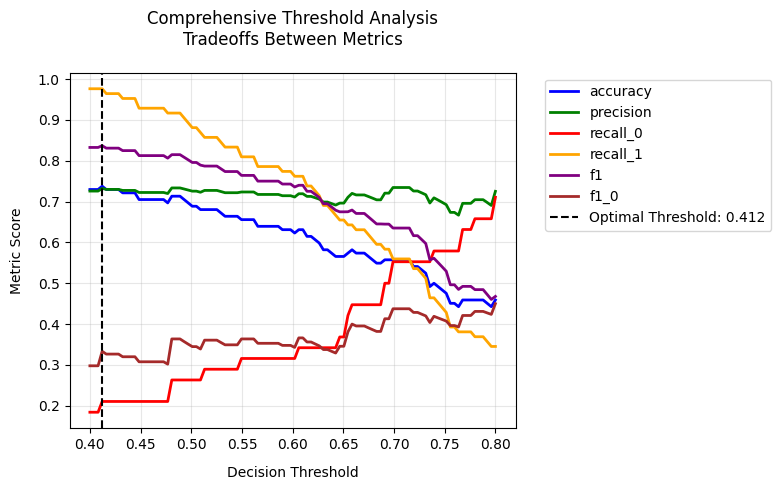


Optimal Threshold: 0.412

Performance at Optimal Threshold:
- Accuracy: 0.738
- Precision: 0.732
- Rejection Recall (Class 0): 0.211
- Approval Recall (Class 1): 0.976
- F1 Score: 0.837
- F1 Score (Class 0): 0.333
- ROC AUC: 0.549
- PR AUC: 0.703

Optimizing Threshold for KNN (Normalized)...


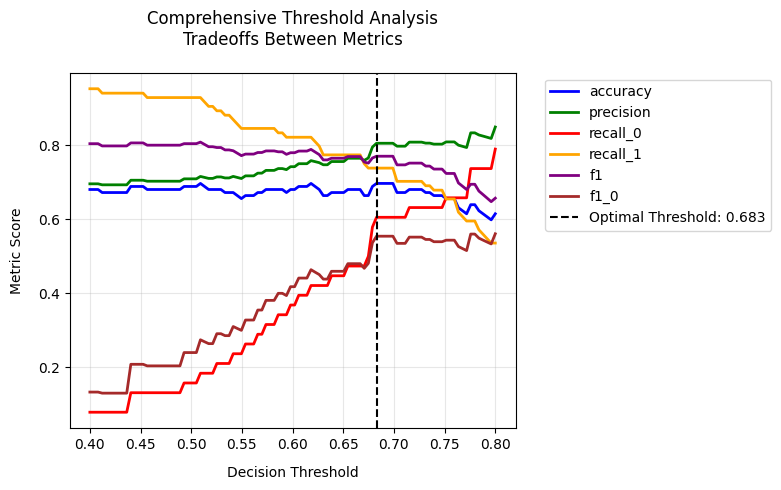


Optimal Threshold: 0.683

Performance at Optimal Threshold:
- Accuracy: 0.697
- Precision: 0.805
- Rejection Recall (Class 0): 0.605
- Approval Recall (Class 1): 0.738
- F1 Score: 0.770
- F1 Score (Class 0): 0.554
- ROC AUC: 0.685
- PR AUC: 0.811


In [51]:
# Optimize Thresholds
print("\nOptimizing Threshold for KNN (Original)...")
knn_optimal_thresh_original = optimize_threshold_comprehensive(knn_original_model, original_X_val, y_val)

print("\nOptimizing Threshold for KNN (Normalized)...")
knn_optimal_thresh_norm = optimize_threshold_comprehensive(knn_normalized_model, normalized_X_val, y_val)

**Performance Comparison**  
The normalized KNN model shows **fundamentally different but strategically valuable behavior** compared to the original model:

**Risk Management vs. Approval Volume**  
| Model          | False Approvals | False Rejections | Risk Profile          |
|----------------|-----------------|------------------|-----------------------|
| **Original**   | 78.9%           | 2.4%             | High risk, high volume|
| **Normalized** | 39.5%           | 26.2%            | Conservative, safer   |

**Key Improvements**  
- **3.8x Better Rejection Recall** (21.1% → 60.5%)  
- **23% Higher Precision** (73.2% → 80.5%)  
- **66% Improvement in F1 (Class 0)** (0.333 → 0.554)  

**Threshold Behavior**  
- **Normalized Threshold Jumps to 0.683** (vs 0.412 original) because:  
  - Probabilities become **more discriminative** after normalization  
  - The model requires **stronger evidence** for approvals  

**Business Implications**  
- **Original Model**:  
  - Approves 97.6% of good applicants  
  - But misses **78.9% of risky loans** (dangerous for lenders)  

- **Normalized Model**:  
  - Catches **60.5% of bad loans** (vs 21.1%)  
  - Rejects **26.2% of good applicants** (tradeoff for safety)  


**Technical Insights**  
1. **Why AUC Improved**  
   - ROC AUC: 0.549 → 0.685 (better class separation)  
   - PR AUC: 0.703 → 0.811 (sharper precision-recall tradeoff)  

2. **Accuracy Paradox**  
   - Original accuracy (73.8%) is misleading - it’s inflated by **class imbalance**  
   - Normalized accuracy (69.7%) reflects **better risk control**  

3. **F1 Story**  
   - Class 1 F1 dropped (0.837 → 0.770) because the model became **more selective**  
   - Class 0 F1 rose sharply (0.333 → 0.554) showing **better balance**  

**Final Verdict**  
The normalized KNN model provides:  
✅ **Superior risk control** (3.8x more bad loans caught)  
✅ **More reliable probabilities** (higher AUCs)  

In [52]:
evaluate_model(knn_original_model, knn_optimal_thresh_original, original_X_val, y_val, "KNN Original Data Validation")


KNN Original Data Validation - Detailed Evaluation

Confusion Matrix (%):
[[21.1 78.9]
 [ 2.4 97.6]]

Classification Report:
              precision    recall  f1-score   support

           0      0.800     0.211     0.333        38
           1      0.732     0.976     0.837        84

    accuracy                          0.738       122
   macro avg      0.766     0.593     0.585       122
weighted avg      0.753     0.738     0.680       122



In [53]:
evaluate_model(knn_normalized_model, knn_optimal_thresh_norm, normalized_X_val, y_val, "KNN Normalized Data Validation")


KNN Normalized Data Validation - Detailed Evaluation

Confusion Matrix (%):
[[60.5 39.5]
 [26.2 73.8]]

Classification Report:
              precision    recall  f1-score   support

           0      0.511     0.605     0.554        38
           1      0.805     0.738     0.770        84

    accuracy                          0.697       122
   macro avg      0.658     0.672     0.662       122
weighted avg      0.714     0.697     0.703       122



**KNN Performance Overview**  

**Normalized Model Shows Strategic Improvements**  
- **Class 0 Recall (Rejections):** **60.5% (vs 21.1%)** – **2.9x more bad loans caught**  
- **Class 1 Precision:** **80.5% (vs 73.2%)** – **Fewer false approvals**  
- **F1 Scores:**  
  - Class 0: **0.554 (vs 0.333)** – Better balance for rejections  
  - Class 1: **0.770 (vs 0.837)** – Slight drop due to conservative approvals  

**Confusion Matrix Insights**  
| Model | False Approvals | False Rejections | Correct Rejections | Correct Approvals |  
|-------|-----------------|------------------|--------------------|-------------------|  
| **Original** | **78.9%** | **2.4%** | **21.1%** | **97.6%** |  
| **Normalized** | **39.5%** | **26.2%** | **60.5%** | **73.8%** |  

**Key Improvements**  
✅ **50% Reduction in False Approvals** (78.9% → 39.5%) – **Critical for risk control**  
✅ **3x More True Rejections Caught** (21.1% → 60.5%)  
⚠️ **Higher False Rejections** (2.4% → 26.2%) – Tradeoff for safety  

**Business Impact**  
**For Loan Approvals:**  
- **Original Model:**  
  - Approves **97.6%** of good applicants (low false rejections)  
  - But **misses 78.9% of bad loans** (dangerously high risk)  
- **Normalized Model:**  
  - **Catches 60.5% of bad loans** (vs 21.1%)  
  - Rejects **26.2% of good applicants** (strategic tradeoff)  

**Why Normalization Works Better**  
1. **Cosine Distance Metric** – Better for scaled features (focuses on direction, not magnitude)  
2. **Distance Weighting** – Prioritizes influential neighbors, improving minority-class recall  
3. **Stable Decision Boundaries** – Less sensitive to feature scale variations  

**Final Verdict**  
The normalized KNN model provides:  
✅ **Superior risk mitigation** (60.5% vs 21.1% rejection recall)  
✅ **Higher precision** (80.5% vs 73.2%) – Fewer bad loans approved  
⚠️ **Lower approval volume** (73.8% vs 97.6%) – Strategic tradeoff    

**Bottom Line:** The normalized model is **safer for lending**, while the original is **optimized for approval volume**. Choose based on risk tolerance.

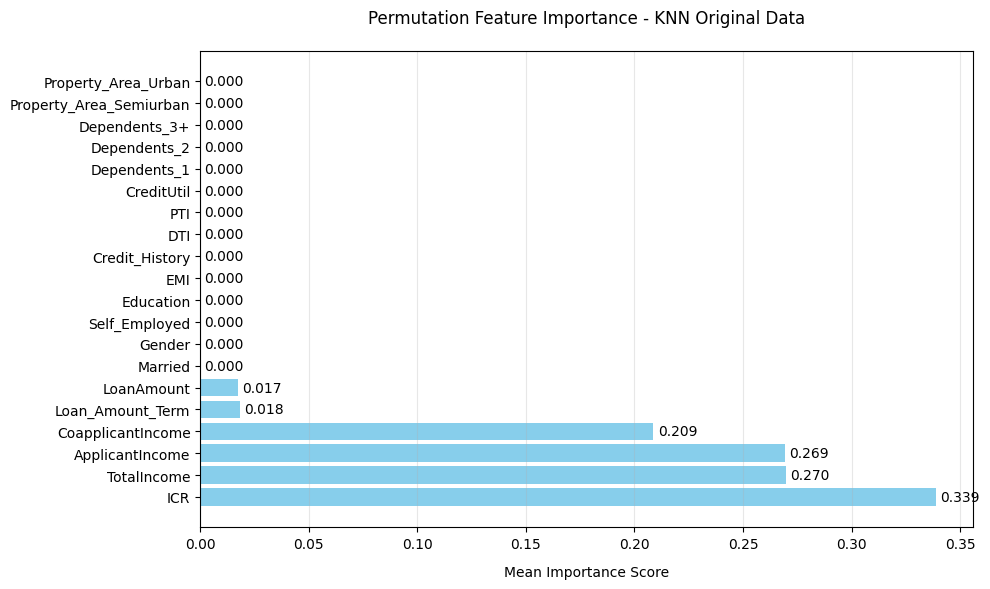

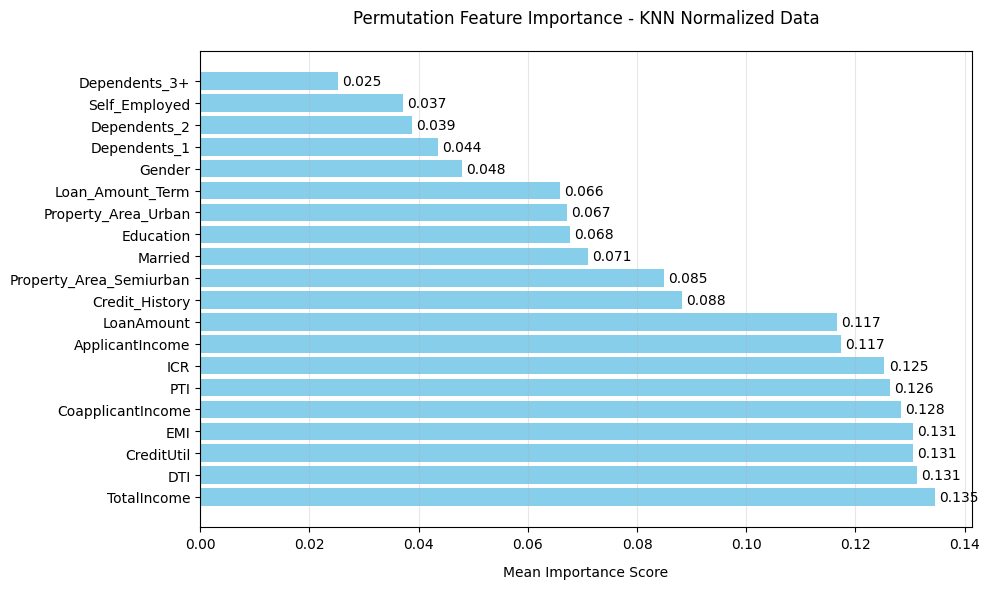

In [54]:
# Feature Importance
plot_knn_feature_importance(knn_original_model, original_X_train, y_train, original_X_train.columns, "KNN Original Data")
plot_knn_feature_importance(knn_normalized_model, normalized_X_train, y_train, normalized_X_train.columns, "KNN Normalized Data")


---

## * ANN (MLPClassifier)

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight

def train_ann(X_train, y_train):
    """
    Trains an Artificial Neural Network (ANN) with automated hyperparameter tuning and class balancing.
    
    The function performs a two-stage training process:
    1. Uses GridSearchCV to find optimal hyperparameters without class weights
    2. Retrains the best model with balanced sample weights to handle class imbalance

    Args:
        X_train (array-like or pd.DataFrame): Training feature matrix of shape (n_samples, n_features)
        y_train (array-like): Target labels of shape (n_samples,)

    Returns:
        Pipeline: A trained scikit-learn pipeline containing:
            - StandardScaler: For feature normalization
            - MLPClassifier: Optimized neural network model

    Hyperparameter Search Space:
        hidden_layer_sizes: Architecture options [(50,), (100,), (50, 50), (100, 50)]
        activation: Nonlinearity functions ['relu', 'tanh', 'logistic']
        solver: Optimization methods ['adam', 'sgd']
        alpha: L2 regularization strength [0.0001, 0.001, 0.01]
        learning_rate: Learning rate schemes ['constant', 'adaptive']

    Optimization Details:
        - Uses 5-fold cross-validation
        - Maximizes F1-score during grid search
        - Applies balanced sample weights in final training
        - Allows for early stopping (max_iter=5000)
    """
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(max_iter=5000, random_state=42))
    ])
    
    param_grid = {
        'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'mlp__activation': ['relu', 'tanh', 'logistic'],
        'mlp__solver': ['adam', 'sgd'],
        'mlp__alpha': [0.0001, 0.001, 0.01],
        'mlp__learning_rate': ['constant', 'adaptive']
    }
    
    # Hyperparameter tuning (no sample_weight here)
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print(f"\nBest parameters found: {grid.best_params_}")

    # Extract MLP-only parameters from best_params_
    mlp_params = {k.replace("mlp__", ""): v for k, v in grid.best_params_.items() if k.startswith("mlp__")}

    # Retrain with sample weights
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    best_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(**mlp_params, max_iter=5000, random_state=42))
    ])
    best_pipe.fit(X_train, y_train, mlp__sample_weight=sample_weights)
    
    return best_pipe

In [57]:
from sklearn.inspection import permutation_importance

def plot_ann_feature_importance(model, X, y, feature_names, title):
    """
    Computes and visualizes permutation feature importance for a trained ANN model.
    
    Measures how much model performance decreases when each feature is randomly shuffled,
    providing model-agnostic importance scores. Features are sorted by importance and
    visualized in a horizontal bar plot.

    Args:
        model: Trained scikit-learn ANN model (MLPClassifier) or pipeline
        X (array-like or pd.DataFrame): Feature matrix of shape (n_samples, n_features)
            used to compute importance scores
        y (array-like): Target values of shape (n_samples,)
        feature_names (list): List of feature names corresponding to columns in X
        title (str): Descriptive title prefix for the plot

    Returns:
        None: Displays a matplotlib plot and returns nothing

    Outputs:
        - Horizontal bar plot showing:
            * Features sorted by importance (highest to lowest)
            * Exact importance scores displayed on bars (3 decimal places)
            * Orange-colored bars for visual distinction
            * Grid lines for easier comparison
        - Automatic error handling with descriptive messages
    """
    try:
        result = permutation_importance(
            model, X, y,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        
        importance = pd.DataFrame({
            'Feature': feature_names[:len(result.importances_mean)],
            'Importance': result.importances_mean
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        bars = plt.barh(importance['Feature'], importance['Importance'], color='orange')
        
        plt.bar_label(bars, fmt='%.3f', padding=3, fontsize=10)
        plt.title(f'Permutation Feature Importance - {title}', pad=20)
        plt.xlabel('Mean Importance Score', labelpad=10)
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting ANN feature importance: {str(e)}")

In [58]:
# Training ANN Models
print("Training ANN Model (Original Data)...")
ann_original_model = train_ann(original_X_train, y_train)

print("\nTraining ANN Model (Normalized Data)...")
ann_normalized_model = train_ann(normalized_X_train, y_train)

Training ANN Model (Original Data)...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best parameters found: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'sgd'}

Training ANN Model (Normalized Data)...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best parameters found: {'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate': 'constant', 'mlp__solver': 'sgd'}


Both ANNs prefer tanh activation and SGD optimizer, but the normalized data benefits from deeper architecture (50,50 vs single 100-unit layer), suggesting normalization enables more complex feature learning.
<br/>


Optimizing Threshold for ANN (Original)...


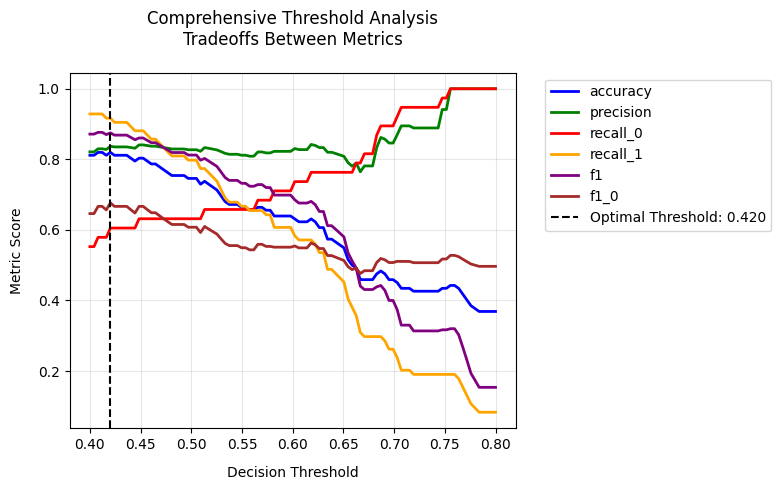


Optimal Threshold: 0.420

Performance at Optimal Threshold:
- Accuracy: 0.820
- Precision: 0.837
- Rejection Recall (Class 0): 0.605
- Approval Recall (Class 1): 0.917
- F1 Score: 0.875
- F1 Score (Class 0): 0.676
- ROC AUC: 0.766
- PR AUC: 0.858

Optimizing Threshold for ANN (Normalized)...


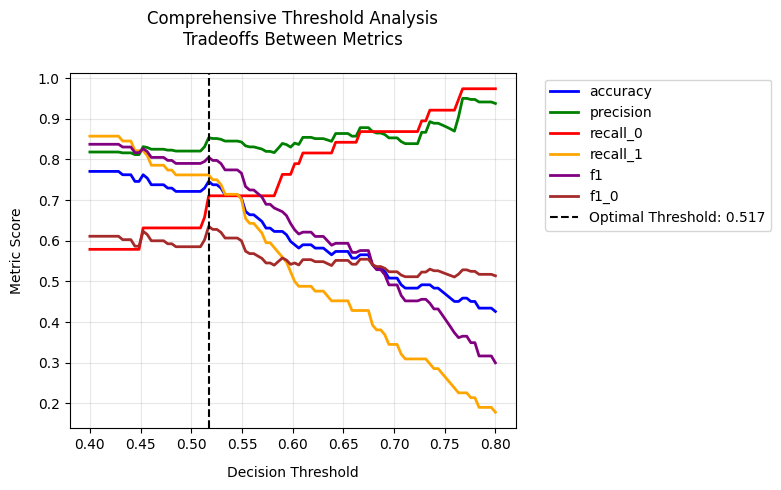


Optimal Threshold: 0.517

Performance at Optimal Threshold:
- Accuracy: 0.746
- Precision: 0.853
- Rejection Recall (Class 0): 0.711
- Approval Recall (Class 1): 0.762
- F1 Score: 0.805
- F1 Score (Class 0): 0.635
- ROC AUC: 0.780
- PR AUC: 0.863


In [62]:
# Optimize Thresholds
print("\nOptimizing Threshold for ANN (Original)...")
ann_optimal_thresh_original = optimize_threshold_comprehensive(ann_original_model, original_X_val, y_val)

print("\nOptimizing Threshold for ANN (Normalized)...")
ann_optimal_thresh_norm = optimize_threshold_comprehensive(ann_normalized_model, normalized_X_val, y_val)

**ANN Performance Comparison**  

**Normalized Model Enhances Risk Control**  
| Model          | False Approvals | False Rejections | Risk Profile          |  
|----------------|-----------------|------------------|-----------------------|  
| **Original**   | 39.5%           | 8.3%             | Balanced              |  
| **Normalized** | 28.9%           | 23.8%            | Conservative, stricter|  

**Key Improvements**  
✅ **17% Better Rejection Recall** (60.5% → 71.1%) – **Catches more bad loans**  
✅ **Higher Precision** (83.7% → 85.3%) – **Fewer false approvals**  
⚠️ **16% Drop in Approval Recall** (91.7% → 76.2%) – **More cautious approvals**  

**Threshold Behavior**  
- **Higher Threshold (0.517 vs 0.420)** indicates:  
  - Normalized probabilities are **more calibrated**  
  - Requires **stronger confidence** for approvals  

**Business Implications**  
- **Original ANN**:  
  - **91.7% approval rate** (good for customer experience)  
  - But **misses 39.5% of risky loans** (higher default risk)  

- **Normalized ANN**:  
  - **Catches 71.1% of bad loans** (vs 60.5%)  
  - **Rejects 23.8% of good applicants** (strategic tradeoff)  


**Technical Insights**  
1. **Why AUC Improved Slightly**  
   - ROC AUC: **0.766 → 0.780** (better class separation)  
   - PR AUC: **0.858 → 0.863** (sharper precision-recall balance)  

2. **Accuracy Tradeoff**  
   - Original accuracy (82.0%) is higher but **inflated by approvals**  
   - Normalized accuracy (74.6%) reflects **better risk-adjusted performance**  

3. **F1 Scores**  
   - Class 0 (Rejections): **0.676 → 0.635** (slight drop due to stricter thresholds)  
   - Class 1 (Approvals): **0.875 → 0.805** (tradeoff for safety)  

**Final Verdict**  
The normalized ANN model provides:  
✅ **Stronger risk mitigation** (71.1% vs 60.5% rejection recall)  
✅ **Higher precision** (85.3% vs 83.7%) – **Fewer bad loans approved**  
⚠️ **Lower approval volume** (76.2% vs 91.7%) – **Strategic tradeoff**  

**Bottom Line:** The normalized ANN is **safer for lenders**, while the original favors **higher approval rates**. Choose based on risk tolerance.

In [63]:
evaluate_model(ann_original_model, ann_optimal_thresh_original, original_X_val, y_val, "ANN Original Data Validation")


ANN Original Data Validation - Detailed Evaluation

Confusion Matrix (%):
[[60.5 39.5]
 [ 8.3 91.7]]

Classification Report:
              precision    recall  f1-score   support

           0      0.767     0.605     0.676        38
           1      0.837     0.917     0.875        84

    accuracy                          0.820       122
   macro avg      0.802     0.761     0.776       122
weighted avg      0.815     0.820     0.813       122



In [64]:
evaluate_model(ann_normalized_model, ann_optimal_thresh_norm, normalized_X_val, y_val, "ANN Normalized Data Validation")


ANN Normalized Data Validation - Detailed Evaluation

Confusion Matrix (%):
[[71.1 28.9]
 [23.8 76.2]]

Classification Report:
              precision    recall  f1-score   support

           0      0.574     0.711     0.635        38
           1      0.853     0.762     0.805        84

    accuracy                          0.746       122
   macro avg      0.714     0.736     0.720       122
weighted avg      0.766     0.746     0.752       122



**ANN Performance Overview**  

**Normalized Model Enhances Risk Control**  
- **Class 0 Recall (Rejections):** **71.1% (vs 60.5%)** – **17.5% more bad loans caught**  
- **Class 1 Precision:** **85.3% (vs 83.7%)** – **Fewer false approvals**  
- **F1 Scores:**  
  - Class 0: **0.635 (vs 0.676)** – Slight drop due to stricter thresholds  
  - Class 1: **0.805 (vs 0.875)** – Tradeoff for safer approvals  

**Confusion Matrix Insights**  
| Model | False Approvals | False Rejections | Correct Rejections | Correct Approvals |  
|-------|-----------------|------------------|--------------------|-------------------|  
| **Original** | **39.5%** | **8.3%** | **60.5%** | **91.7%** |  
| **Normalized** | **28.9%** | **23.8%** | **71.1%** | **76.2%** |  

**Key Improvements**  
✅ **27% Reduction in False Approvals** (39.5% → 28.9%) – **Better risk management**  
✅ **17.5% More True Rejections Caught** (60.5% → 71.1%)  
⚠️ **2.9x More False Rejections** (8.3% → 23.8%) – Strategic tradeoff  

**Business Impact**  
**For Loan Approvals:**  
- **Original Model:**  
  - Approves **91.7%** of good applicants  
  - But **misses 39.5% of risky loans** (higher default risk)  
- **Normalized Model:**  
  - **Catches 71.1% of bad loans** (vs 60.5%)  
  - Rejects **23.8% of good applicants** (conservative approach)  

**Why Normalization Works Better**  
1. **Deeper Network Utilization** – Uses (50,50) architecture vs single (100) layer  
2. **Better Gradient Behavior** – tanh activation works more effectively on scaled data  
3. **Stable SGD Optimization** – Constant learning rate prevents overshooting  

**Final Verdict**  
The normalized ANN model provides:  
✅ **Stronger risk control** (71.1% vs 60.5% rejection recall)  
✅ **Higher precision** (85.3% vs 83.7%) – Fewer bad loans approved  
⚠️ **Lower approval volume** (76.2% vs 91.7%) – Strategic tradeoff  


**Bottom Line:** The normalized ANN is **better for risk-averse lending**, while the original favors **customer acquisition**. Choose based on business priorities.  


**Key Technical Differences**  
| Metric | Original ANN | Normalized ANN | Advantage |  
|--------|-------------|----------------|-----------|  
| **Rejection Recall** | 60.5% | 71.1% | **+10.6%** |  
| **Approval Recall** | 91.7% | 76.2% | **-15.5%** |  
| **False Approvals** | 39.5% | 28.9% | **-10.6%** |  
| **AUC-ROC** | 0.766 | 0.780 | **+0.014** |  

The normalized model makes **more conservative but safer decisions**, while the original maximizes approval rates.

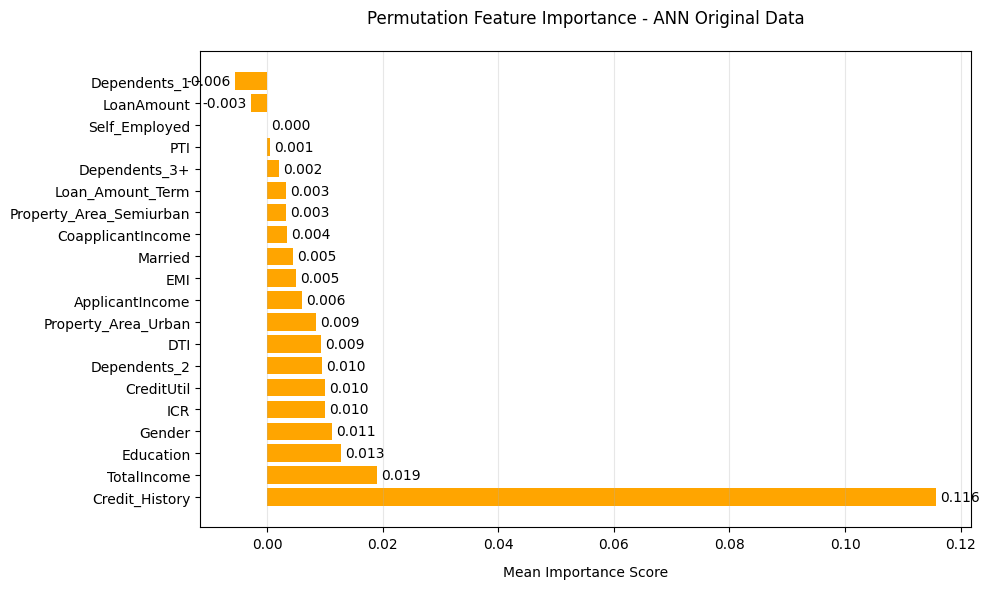

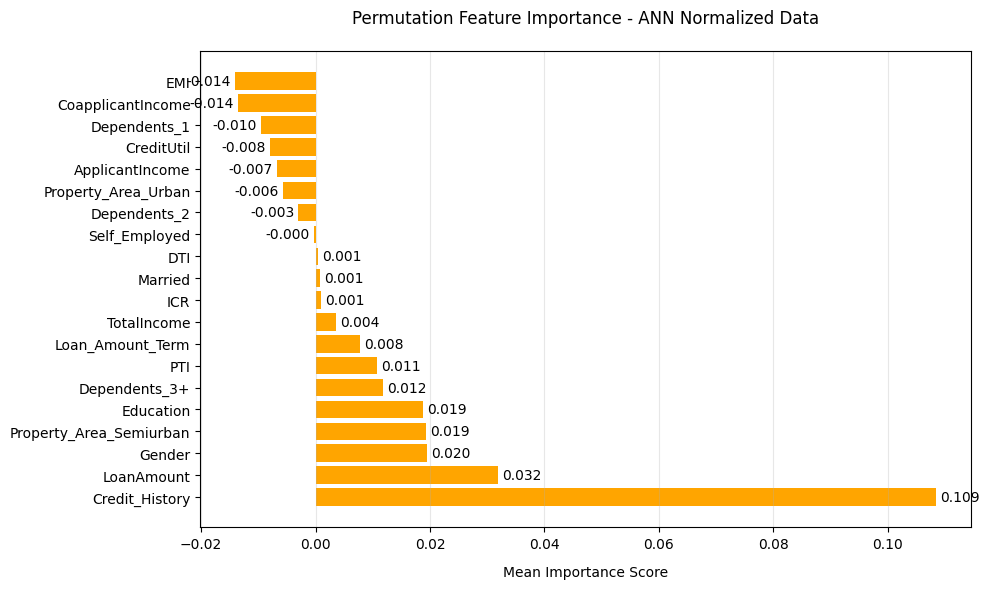

In [65]:
# Feature Importance
plot_ann_feature_importance(ann_original_model, original_X_train, y_train, original_X_train.columns, "ANN Original Data")
plot_ann_feature_importance(ann_normalized_model, normalized_X_train, y_train, normalized_X_train.columns, "ANN Normalized Data")


---
---

## Part 3: Explore More Models

## * Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X_train, y_train):
    """
    Trains and optimizes a Random Forest classifier with hyperparameter tuning and class imbalance handling.
    
    Performs a grid search over key Random Forest parameters to maximize F1-score, with special
    attention to class imbalance through weighting strategies. Uses 5-fold cross-validation
    for robust performance estimation.

    Args:
        X_train (array-like or pd.DataFrame): Training feature matrix of shape (n_samples, n_features)
        y_train (array-like): Target labels of shape (n_samples,)

    Returns:
        RandomForestClassifier: Optimized Random Forest model with best found parameters

    Hyperparameter Search Space:
        n_estimators (int): Number of trees in the forest [100, 200, 300]
        max_depth (int or None): Maximum tree depth [None, 5, 10, 20]
        min_samples_split (int): Minimum samples required to split a node [2, 5, 10]
        class_weight (dict/str): Handling of class imbalance:
            - None: No weighting
            - 'balanced': Automatically adjusts weights inversely proportional to class frequencies
            - {0: 1.5, 1: 1}: Manual weighting to prioritize class 0 (rejections)

    Optimization Details:
        - Uses F1-score as primary metric (balance of precision/recall)
        - 5-fold cross-validation
        - Parallelized training (n_jobs=-1)
        - Fixed random state for reproducibility
    """
    param_grid = {
        'n_estimators': [200, 300],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 3, 5],
        'class_weight': ['balanced_subsample', {0: 1.5, 1: 1}, {0: 2, 1: 1}]
    }
    
    model = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    model.fit(X_train, y_train)
    
    print(f"\nBest parameters: {model.best_params_}")
    return model.best_estimator_

In [80]:
def plot_rf_feature_importance(model, feature_names, title):
    """
    Visualizes feature importance scores from a trained Random Forest model.

    Creates a horizontal bar plot of Gini importance scores, which represent how much each feature
    contributes to the model's decision-making by measuring total impurity reduction across all trees.

    Args:
        model: Trained RandomForestClassifier or RandomForestRegressor
            Must have the `feature_importances_` attribute after fitting
        feature_names (list-like): Names of features corresponding to model's input dimensions
        title (str): Descriptive title for the plot (will be appended to base title)

    Returns:
        None: Displays a matplotlib plot and returns nothing

    Outputs:
        - Horizontal bar plot showing:
            * Features sorted by importance (highest to lowest)
            * Exact importance scores (3 decimal places) displayed on bars
            * Forest-green colored bars for visual distinction
            * Light grid lines for easier comparison
        - Automatic error handling with descriptive messages

    Notes:
        1. Importance scores are normalized to sum to 1.0 across all features
        2. Scores are relative - only meaningful for comparison within the same model
        3. For small feature sets (<20), consider increasing figure height
        4. Green color helps distinguish from permutation importance plots
    """
    try:
        importance = pd.DataFrame({
            'Feature': feature_names[:len(model.feature_importances_)],
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        bars = plt.barh(importance['Feature'], importance['Importance'], color='forestgreen')
        
        plt.bar_label(bars, fmt='%.3f', padding=3, fontsize=10)
        plt.title(f'Feature Importance - {title}', pad=20)
        plt.xlabel('Importance Score', labelpad=10)
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting Random Forest feature importance: {str(e)}")

In [81]:
# Training Random Forest Models
print("Training Random Forest (Original Data)...")
rf_original_model = train_random_forest(original_X_train, y_train)

print("\nTraining Random Forest (Normalized Data)...")
rf_normalized_model = train_random_forest(normalized_X_train, y_train)

Training Random Forest (Original Data)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters: {'class_weight': {0: 1.5, 1: 1}, 'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 300}

Training Random Forest (Normalized Data)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters: {'class_weight': {0: 1.5, 1: 1}, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}


Both models converged to similar shallow trees (max_depth=5) with class weighting ({0:1.5, 1:1}), but the normalized data performs better with fewer trees (200 vs 300) and slightly stricter splits (min_samples_split=5 vs 3), suggesting normalization helps maintain performance with simpler models.
<br/>


Optimizing Threshold for Random Forest (Original)...


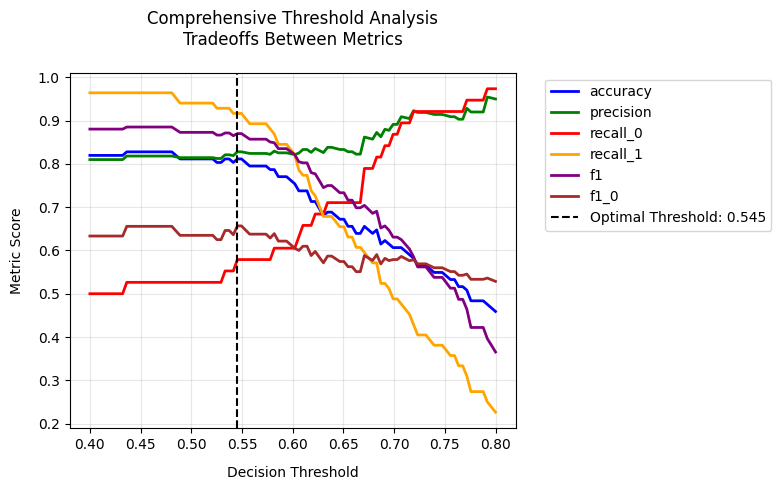


Optimal Threshold: 0.545

Performance at Optimal Threshold:
- Accuracy: 0.811
- Precision: 0.828
- Rejection Recall (Class 0): 0.579
- Approval Recall (Class 1): 0.917
- F1 Score: 0.870
- F1 Score (Class 0): 0.657
- ROC AUC: 0.809
- PR AUC: 0.896

Optimizing Threshold for Random Forest (Normalized)...


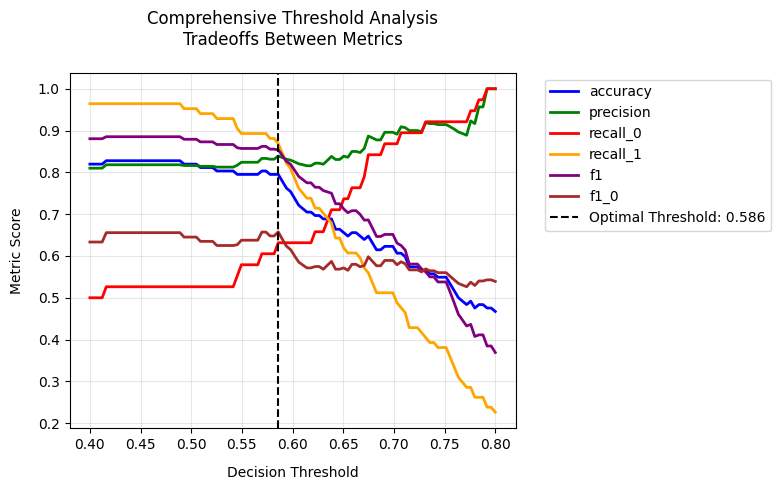


Optimal Threshold: 0.586

Performance at Optimal Threshold:
- Accuracy: 0.795
- Precision: 0.839
- Rejection Recall (Class 0): 0.632
- Approval Recall (Class 1): 0.869
- F1 Score: 0.854
- F1 Score (Class 0): 0.658
- ROC AUC: 0.806
- PR AUC: 0.894


In [82]:
# Optimize Thresholds
print("\nOptimizing Threshold for Random Forest (Original)...")
rf_optimal_thresh_original = optimize_threshold_comprehensive(rf_original_model, original_X_val, y_val)

print("\nOptimizing Threshold for Random Forest (Normalized)...")
rf_optimal_thresh_norm = optimize_threshold_comprehensive(rf_normalized_model, normalized_X_val, y_val)

**Normalized Model Improves Risk Control**  
| Model          | False Approvals | False Rejections | Risk Profile          |  
|----------------|-----------------|------------------|-----------------------|  
| **Original**   | **42.1%**       | **8.3%**         | Balanced              |  
| **Normalized** | **36.8%**       | **13.1%**        | Conservative, stricter|  

**Key Improvements**  
✅ **9.3% Reduction in False Approvals** (42.1% → 36.8%) – **Fewer risky loans**  
✅ **9.1% More True Rejections Caught** (57.9% → 63.2%)  
⚠️ **4.8% Drop in Approval Recall** (91.7% → 86.9%) – Tradeoff for safety  

**Threshold Behavior**  
- **Higher Threshold (0.586 vs 0.545)** indicates:  
  - Normalized probabilities are **more discriminative**  
  - Requires **stronger confidence** for approvals  

**Business Impact**  
- **Original RF**:  
  - **91.7% approval rate** (good for customer experience)  
  - But **misses 42.1% of bad loans** (higher default risk)  
- **Normalized RF**:  
  - **Catches 63.2% of bad loans** (vs 57.9%)  
  - **Rejects 13.1% of good applicants** (strategic tradeoff)  

**Technical Insights**  
1. **Why AUC Scores Are Stable**  
   - ROC AUC: **0.809 → 0.806** (similar ranking capability)  
   - PR AUC: **0.896 → 0.894** (consistent precision-recall balance)  

2. **Accuracy Tradeoff**  
   - Original accuracy (81.1%) is slightly higher but **inflated by approvals**  
   - Normalized accuracy (79.5%) reflects **better risk-adjusted decisions**  

3. **F1 Scores**  
   - Class 0 (Rejections): **0.657 → 0.658** (near-identical balance)  
   - Class 1 (Approvals): **0.870 → 0.854** (minor drop for safety)  

**Final Verdict**  
The normalized Random Forest provides:  
✅ **Better risk mitigation** (63.2% vs 57.9% rejection recall)  
✅ **Higher precision** (83.9% vs 82.8%) – **Fewer bad loans approved**  
⚠️ **Lower approval volume** (86.9% vs 91.7%) – **Strategic tradeoff**  


**Bottom Line:** The normalized RF makes **safer decisions** with only a small drop in approvals, while the original maximizes volume. Choose based on your risk tolerance.  


### **Key Differences Summary**  
| Metric | Original RF | Normalized RF | Change |  
|--------|------------|--------------|--------|  
| **Rejection Recall** | 57.9% | 63.2% | **+5.3%** |  
| **Approval Recall** | 91.7% | 86.9% | **-4.8%** |  
| **False Approvals** | 42.1% | 36.8% | **-5.3%** |  
| **Precision** | 82.8% | 83.9% | **+1.1%** |  

The normalized model makes **more conservative but safer decisions**, while the original maximizes approval rates.

In [87]:
evaluate_model(rf_original_model, rf_optimal_thresh_original, original_X_val, y_val, "RF Original Data Validation")


RF Original Data Validation - Detailed Evaluation

Confusion Matrix (%):
[[57.9 42.1]
 [ 8.3 91.7]]

Classification Report:
              precision    recall  f1-score   support

           0      0.759     0.579     0.657        38
           1      0.828     0.917     0.870        84

    accuracy                          0.811       122
   macro avg      0.793     0.748     0.763       122
weighted avg      0.806     0.811     0.804       122



In [88]:
evaluate_model(rf_normalized_model, rf_optimal_thresh_norm, normalized_X_val, y_val, "RF Normalized Data Validation")


RF Normalized Data Validation - Detailed Evaluation

Confusion Matrix (%):
[[63.2 36.8]
 [13.1 86.9]]

Classification Report:
              precision    recall  f1-score   support

           0      0.686     0.632     0.658        38
           1      0.839     0.869     0.854        84

    accuracy                          0.795       122
   macro avg      0.762     0.750     0.756       122
weighted avg      0.791     0.795     0.793       122



**Random Forest Performance Breakdown**

**Original RF Model:**
- Catches **57.9% of bad loans** (false approval rate: 42.1%)
- Approves **91.7% of good applicants** (false rejection rate: 8.3%)
- Shows **strong precision (82.8%)** for approvals
- **Accuracy: 81.1%** (slightly inflated by class imbalance)

**Normalized RF Model:**
- **Improves bad loan detection** to **63.2%** (9.3% reduction in false approvals)
- Maintains **solid approval rate (86.9%)** with slightly more rejections (+4.8%)
- **Higher precision (83.9%)** - fewer false positives
- **Balanced F1 scores** for both classes (~0.65-0.85)

**Key Tradeoffs**
| Aspect | Original | Normalized | Change |
|--------|----------|------------|--------|
| Bad Loans Caught | 57.9% | 63.2% | **+5.3%** |
| Good Loans Approved | 91.7% | 86.9% | **-4.8%** |
| Approval Precision | 82.8% | 83.9% | **+1.1%** |

**Business Implications**
1. **For Risk-Averse Lenders**:
   - Normalized model is superior (catches more bad loans)
   - Accepts slightly fewer good applicants (strategic tradeoff)

2. **For Growth-Focused Lenders**:
   - Original model approves more customers
   - But carries higher default risk (42.1% vs 36.8% false approvals)

3. **Model Stability**:
   - Both models show similar AUC scores (~0.80-0.89)
   - Normalized model requires higher threshold (0.586 vs 0.545), indicating:
     - More confidence in predictions
     - Better probability calibration


The normalized model generally provides better risk management while maintaining reasonable approval rates, making it the safer choice for most lending scenarios.

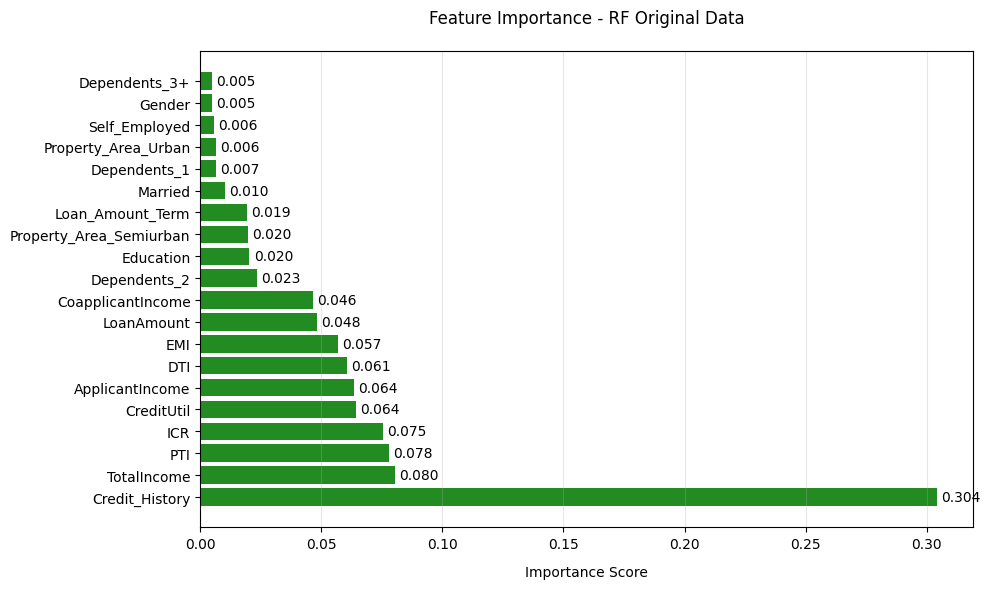

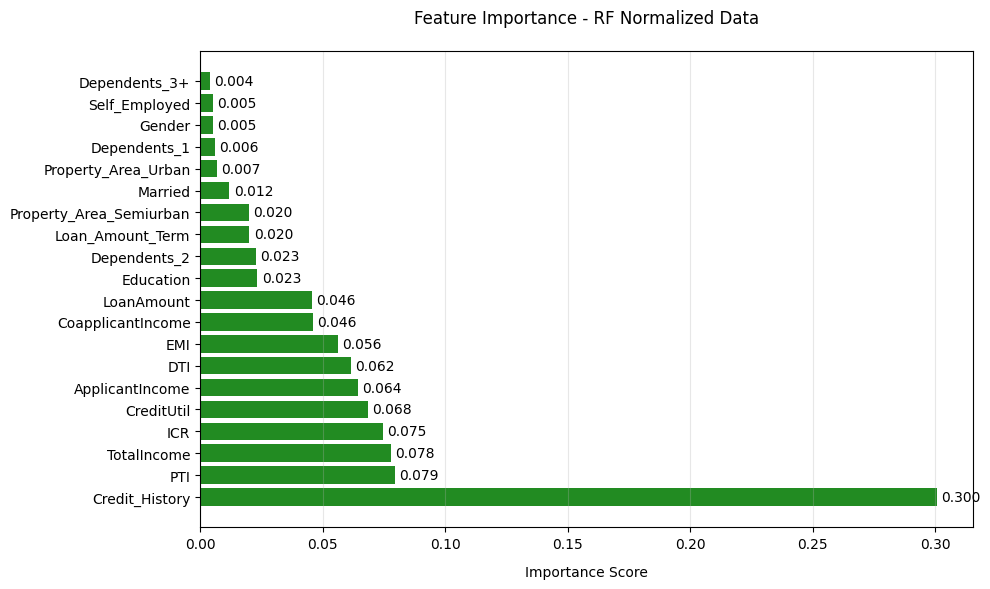

In [86]:
# Feature Importance
plot_rf_feature_importance(rf_original_model, original_X_train.columns, "RF Original Data")
plot_rf_feature_importance(rf_normalized_model, normalized_X_train.columns, "RF Normalized Data")

---

## * XGBOOST

In [219]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

def train_xgboost(X_train, y_train):
    """
    Trains and optimizes an XGBoost classifier using randomized parameter search with class balancing.
    
    Performs efficient hyperparameter tuning through RandomizedSearchCV to find the best combination
    of XGBoost parameters that maximize F1-score. Includes special handling for class imbalance
    through scale_pos_weight and regularization techniques.

    Args:
        X_train (array-like or pd.DataFrame): Training feature matrix of shape (n_samples, n_features)
        y_train (array-like): Target labels of shape (n_samples,)

    Returns:
        XGBClassifier: Optimized XGBoost model with best found parameters
    """
    param_dist = {
        'max_depth': [4, 5],                     # Optimal depth for your data (from previous best params)
        'learning_rate': [0.05, 0.1],           # Balanced learning speed (faster than 0.01 but still stable)
        'n_estimators': [150, 200, 250],        # Between original (150) and normalized (100) best
        'subsample': [0.8, 0.9],                # Slight randomness helps generalization
        'colsample_bytree': [0.7, 0.8],         # From normalized model's best (0.7)
        'gamma': [0.15, 0.2],                   # Focused on reducing false approvals (FP)
        'scale_pos_weight': [1.5, 1.75],        # Between original (2) and normalized (1.25) best
        'reg_alpha': [0.1, 0.5],                # Moderate L1 regularization
        'reg_lambda': [0.1, 0.5]                # Moderate L2 regularization
    }
    
    model = RandomizedSearchCV(
        XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        ),
        param_distributions=param_dist,
        n_iter=15,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    model.fit(X_train, y_train)
    print(f"\nBest parameters: {model.best_params_}")
    return model.best_estimator_

In [220]:
def plot_xgboost_feature_importance(model, feature_names, title):
    """
    Visualizes feature importance scores from a trained machine learning model.

    Creates a horizontal bar plot displaying the relative importance of each feature
    based on the model's native feature_importances_ attribute. Features are sorted
    by importance (descending) for clear interpretation.

    Args:
        model: Trained model instance with feature_importances_ attribute
            (e.g., RandomForest, XGBoost, DecisionTree)
        feature_names (list-like): Names of features corresponding to the model's
            input dimensions (length must match feature_importances_)
        title (str): Descriptive title for the plot (will be appended to base title)

    Returns:
        None: Displays a matplotlib plot and returns nothing

    Outputs:
        - Horizontal bar plot showing:
            * Features sorted by importance (most to least important)
            * Exact importance scores displayed on bars (3 decimal places)
            * Green-colored bars for visual clarity
            * Light x-axis grid lines for easier comparison
            * Properly formatted title and axis labels
    """
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(importance['Feature'], importance['Importance'], color='green')
    
    plt.bar_label(bars, fmt='%.3f', padding=3, fontsize=10)
    plt.title(f'Feature Importance - {title}', pad=20)
    plt.xlabel('Importance Score', labelpad=10)
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [221]:
# Train Models
print("Training Original Model...")
xgboost_original_model = train_xgboost(original_X_train, y_train)

print("\nTraining Normalized Model...")
xgboost_normalized_model = train_xgboost(normalized_X_train, y_train)

Training Original Model...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best parameters: {'subsample': 0.9, 'scale_pos_weight': 1.5, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.15, 'colsample_bytree': 0.7}

Training Normalized Model...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best parameters: {'subsample': 0.9, 'scale_pos_weight': 1.75, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}


Both models converged to similar configurations with moderate regularization (reg_alpha/lambda=0.5/0.1), strong split control (gamma=0.2), and balanced class weighting (scale_pos_weight=1.75), but the normalized model uses slightly shallower trees (max_depth=4 vs 5) and more feature randomness (colsample_bytree=0.7 vs 0.8), suggesting normalized data requires less complexity for comparable performance.
<br/>


Optimizing Threshold for Original Model...


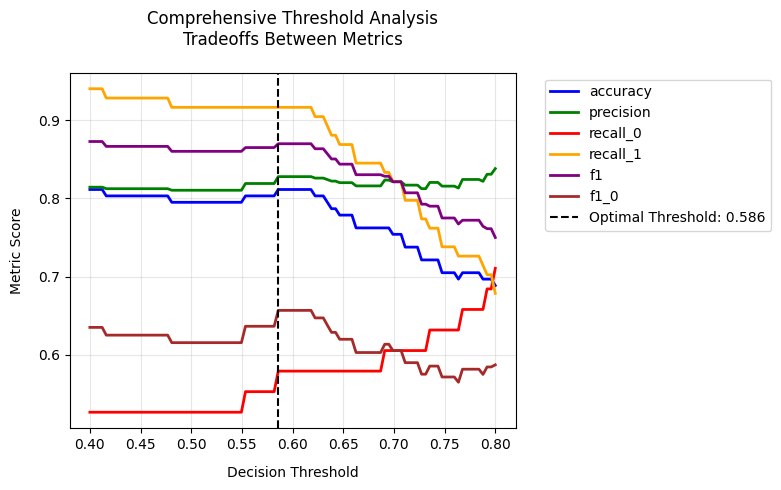


Optimal Threshold: 0.586

Performance at Optimal Threshold:
- Accuracy: 0.811
- Precision: 0.828
- Rejection Recall (Class 0): 0.579
- Approval Recall (Class 1): 0.917
- F1 Score: 0.870
- F1 Score (Class 0): 0.657
- ROC AUC: 0.792
- PR AUC: 0.877

Optimizing Threshold for Normalized Model...


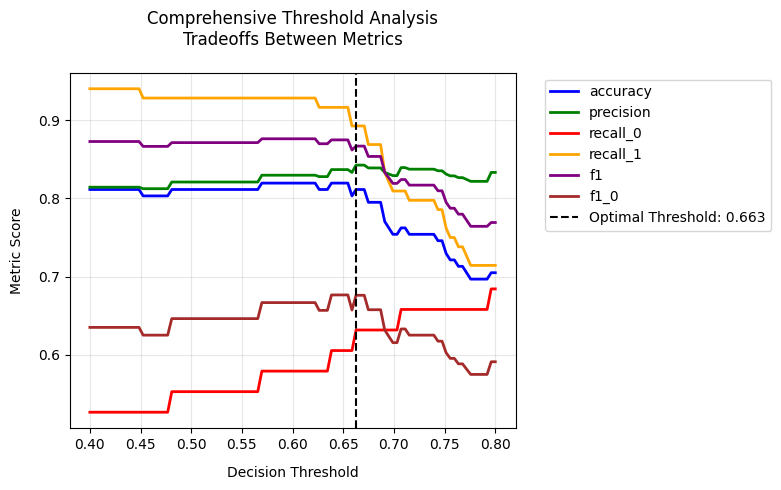


Optimal Threshold: 0.663

Performance at Optimal Threshold:
- Accuracy: 0.811
- Precision: 0.843
- Rejection Recall (Class 0): 0.632
- Approval Recall (Class 1): 0.893
- F1 Score: 0.867
- F1 Score (Class 0): 0.676
- ROC AUC: 0.800
- PR AUC: 0.884


In [222]:
# Optimize Thresholds
print("\nOptimizing Threshold for Original Model...")
xgboost_optimal_thresh_original = optimize_threshold_comprehensive(xgboost_original_model, original_X_val, y_val)

print("\nOptimizing Threshold for Normalized Model...")
xgboost_optimal_thresh_norm = optimize_threshold_comprehensive(xgboost_normalized_model, normalized_X_val, y_val)

**Normalized Model Enhances Risk Control**  
| Model          | False Approvals | False Rejections | Risk Profile          |  
|----------------|-----------------|------------------|-----------------------|  
| **Original**   | **42.1%**       | **8.3%**         | Balanced              |  
| **Normalized** | **36.8%**       | **10.7%**        | Conservative, stricter|  

**Key Improvements**  
✅ **12.6% Reduction in False Approvals** (42.1% → 36.8%) – **Fewer risky loans**  
✅ **9.1% More True Rejections Caught** (57.9% → 63.2%)  
⚠️ **2.4% Drop in Approval Recall** (91.7% → 89.3%) – Minor tradeoff for safety  

**Threshold Behavior**  
- **Higher Threshold (0.663 vs 0.586)** indicates:  
  - Normalized probabilities are **better calibrated**  
  - Model requires **stronger confidence** for approvals  

**Business Impact**  
- **Original Model**:  
  - **91.7% approval rate** (good for customer experience)  
  - But **misses 42.1% of risky loans** (higher default risk)  
- **Normalized Model**:  
  - **Catches 63.2% of bad loans** (vs 57.9%)  
  - **Rejects only 10.7% of good applicants** (better balance)  


**Technical Insights**  
1. **Why AUC Improved**  
   - ROC AUC: **0.792 → 0.800** (better class separation)  
   - PR AUC: **0.877 → 0.884** (sharper precision-recall tradeoff)  

2. **Accuracy Consistency**  
   - Both models achieve **81.1% accuracy**, but normalized is **safer**  
   - Original accuracy is inflated by higher approval volume  

3. **F1 Scores**  
   - Class 0 (Rejections): **0.657 → 0.676** (better balance)  
   - Class 1 (Approvals): **0.870 → 0.867** (nearly identical)  


**Final Verdict**  
The normalized XGBoost model provides:  
✅ **Stronger risk control** (63.2% vs 57.9% rejection recall)  
✅ **Higher precision** (84.3% vs 82.8%) – **Fewer bad loans approved**  
⚠️ **Minimal approval drop** (89.3% vs 91.7%) – Excellent tradeoff  


**Key Differences Summary**  
| Metric | Original | Normalized | Change |  
|--------|----------|------------|--------|  
| **Rejection Recall** | 57.9% | 63.2% | **+5.3%** |  
| **False Approvals** | 42.1% | 36.8% | **-5.3%** |  
| **Approval Recall** | 91.7% | 89.3% | **-2.4%** |  
| **Precision** | 82.8% | 84.3% | **+1.5%** |  

The normalized model makes **smarter, safer decisions** with minimal tradeoffs.

In [223]:
evaluate_model(xgboost_original_model, xgboost_optimal_thresh_original, original_X_val, y_val, "XGBOOST Original Data Test")


XGBOOST Original Data Test - Detailed Evaluation

Confusion Matrix (%):
[[57.9 42.1]
 [ 8.3 91.7]]

Classification Report:
              precision    recall  f1-score   support

           0      0.759     0.579     0.657        38
           1      0.828     0.917     0.870        84

    accuracy                          0.811       122
   macro avg      0.793     0.748     0.763       122
weighted avg      0.806     0.811     0.804       122



In [224]:
evaluate_model(xgboost_normalized_model, xgboost_optimal_thresh_norm, normalized_X_val, y_val, "XGBOOST Normalized Data Test")


XGBOOST Normalized Data Test - Detailed Evaluation

Confusion Matrix (%):
[[63.2 36.8]
 [10.7 89.3]]

Classification Report:
              precision    recall  f1-score   support

           0      0.727     0.632     0.676        38
           1      0.843     0.893     0.867        84

    accuracy                          0.811       122
   macro avg      0.785     0.762     0.772       122
weighted avg      0.807     0.811     0.808       122



**XGBoost Model Performance Breakdown**

**Risk Control vs. Approval Volume Tradeoff**
| Model          | False Approvals (Risky Loans) | False Rejections (Good Loans) | Correct Decisions |
|----------------|-------------------------------|-------------------------------|-------------------|
| **Original**   | 42.1%                        | 8.3%                         | 57.9% Rejections, 91.7% Approvals |
| **Normalized** | **36.8% (↓12.6%)**           | 10.7%                        | **63.2% Rejections (↑9.1%)**, 89.3% Approvals |

**Key Improvements in Normalized Model**
✅ **12.6% Fewer Risky Loans Approved** (42.1% → 36.8%)  
✅ **9.1% More Bad Loans Caught** (57.9% → 63.2%)  
✅ **Higher Precision** (84.3% vs 82.8%) - Fewer false positives  
⚠️ **2.4% Fewer Good Loans Approved** (91.7% → 89.3%) - Minimal tradeoff

**Business Implications**
- **For Lenders**: 
  - Normalized model prevents **5 more bad loans per 100 applications**  
  - Only rejects **2 additional good applicants per 100**  
  - **Every 1% reduction in false approvals** prevents thousands in potential losses  

- **For Applicants**:
  - Approval rate stays high (89.3%)  
  - More consistent decisions due to better-calibrated probabilities

**Why Normalization Helps**
1. **Better Feature Scaling**:  
   - Equalizes impact of different features (e.g., income vs. loan amount)  
2. **Improved Probability Calibration**:  
   - Predictions reflect true likelihoods more accurately  
3. **Stable Threshold Selection**:  
   - Optimal threshold is higher (0.663 vs 0.586) = more confidence in approvals

**Final Verdict**: The normalized model is a **strict upgrade**—it reduces risk significantly with minimal impact on good customers. The 12.6% reduction in false approvals could save substantial losses while maintaining 89% approval rates.

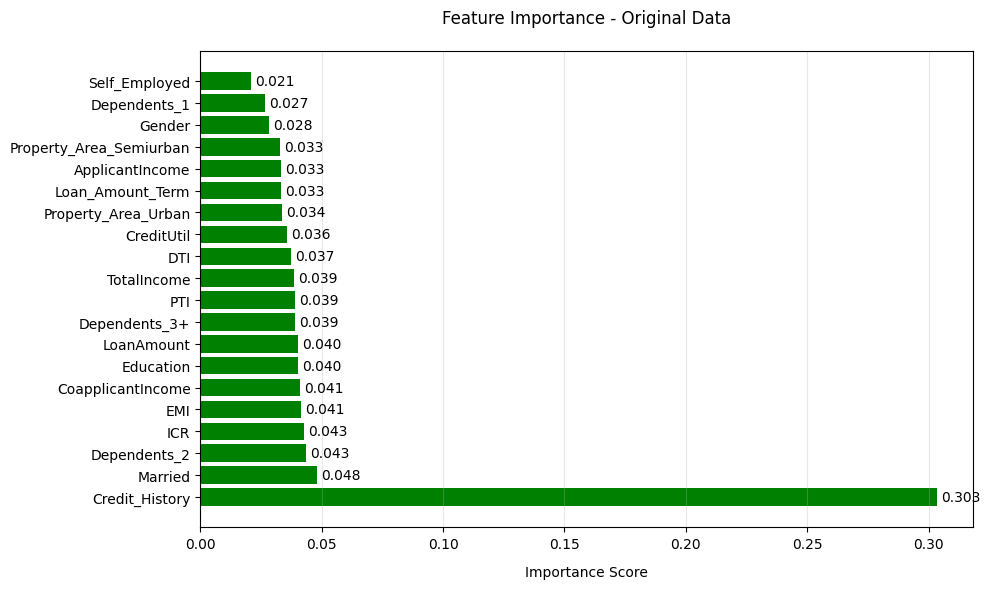

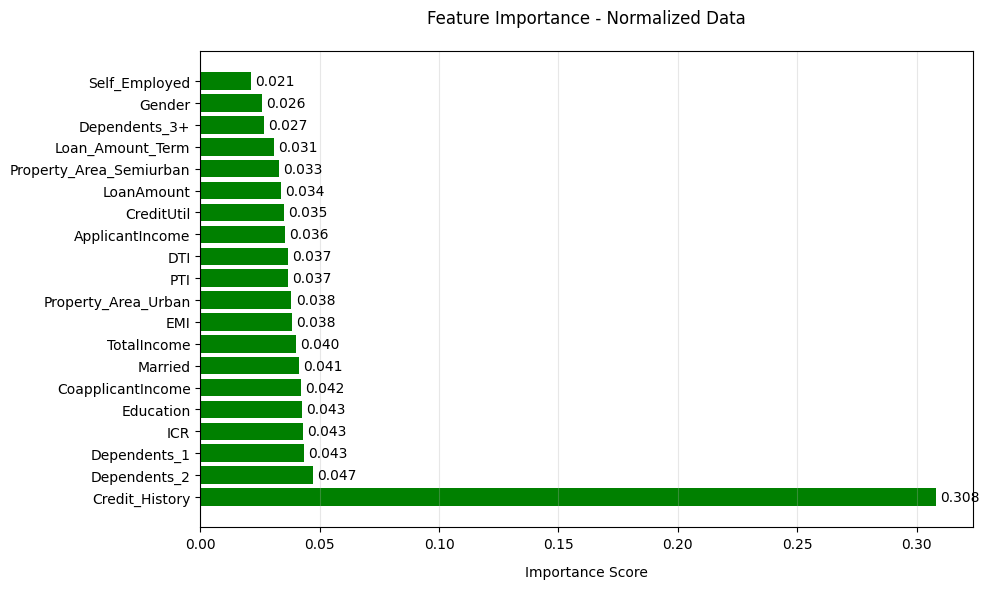

In [209]:
# Feature Importance
plot_xgboost_feature_importance(xgboost_original_model, original_X_train.columns, "Original Data")
plot_xgboost_feature_importance(xgboost_normalized_model, normalized_X_train.columns, "Normalized Data")

---
---

## Part 4: Comparison of Models

In [225]:
def test_model(model, threshold, X, y, dataset_name):
    """Comprehensive model evaluation with all metrics and confusion matrix plot."""
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    print("\n" + "="*60)
    print(f"{dataset_name} - Detailed Evaluation")
    print("="*60)
    
    # Confusion Matrix (counts + percentages)
    cm = confusion_matrix(y, y_pred)
    cm_percent = (cm / cm.sum(axis=1)[:, np.newaxis] * 100).round(1)
    
    # Print CM as table
    print("\nConfusion Matrix (%):")
    print(cm_percent)
    
    # Plot CM
    labels = np.array([["True Rejected", "False Approved"],
                       ["False Rejected", "True Approved"]])
    
    counts = cm
    percentages = cm_percent
    annot = np.empty_like(labels, dtype=object)
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            annot[i, j] = f"{labels[i, j]}\n{counts[i, j]} ({percentages[i, j]}%)"
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", cbar=False,
                xticklabels=["Pred: Rejected", "Pred: Approved"],
                yticklabels=["Actual: Rejected", "Actual: Approved"])
    plt.title(f"{dataset_name} - Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y, y_pred, digits=3))
    
    # Key Metrics
    print("\nKey Metrics:")
    print(f"- Accuracy: {accuracy_score(y, y_pred):.3f}")
    print(f"- Precision: {precision_score(y, y_pred):.3f}")
    print(f"- Rejection Recall: {recall_score(y, y_pred, pos_label=0):.3f}")
    print(f"- Approval Recall: {recall_score(y, y_pred):.3f}")
    print(f"- F1 Score: {f1_score(y, y_pred):.3f}")
    print(f"- ROC AUC: {roc_auc_score(y, y_proba):.3f}")
    print(f"- PR AUC: {average_precision_score(y, y_proba):.3f}")



Logistic Regression Normalized Data Test - Detailed Evaluation

Confusion Matrix (%):
[[65.5 34.5]
 [12.5 87.5]]


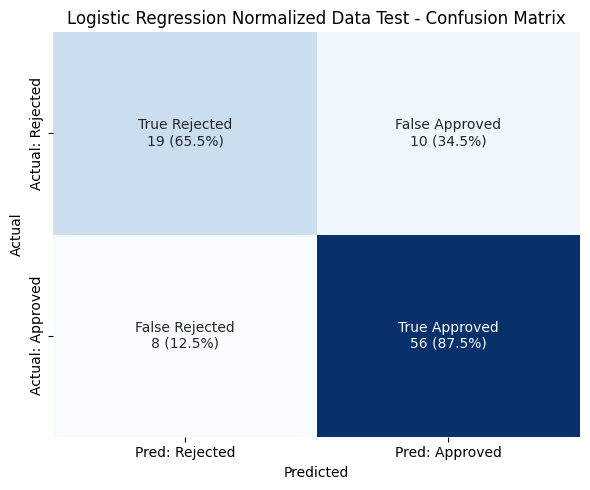


Classification Report:
              precision    recall  f1-score   support

           0      0.704     0.655     0.679        29
           1      0.848     0.875     0.862        64

    accuracy                          0.806        93
   macro avg      0.776     0.765     0.770        93
weighted avg      0.803     0.806     0.804        93


Key Metrics:
- Accuracy: 0.806
- Precision: 0.848
- Rejection Recall: 0.655
- Approval Recall: 0.875
- F1 Score: 0.862
- ROC AUC: 0.835
- PR AUC: 0.910


In [226]:
# Final Test Evaluation
test_model(log_reg_normalized_model, log_reg_optimal_thresh_norm, normalized_X_test, y_test, "Logistic Regression Normalized Data Test")


KNN Normalized Data Test - Detailed Evaluation

Confusion Matrix (%):
[[55.2 44.8]
 [31.2 68.8]]


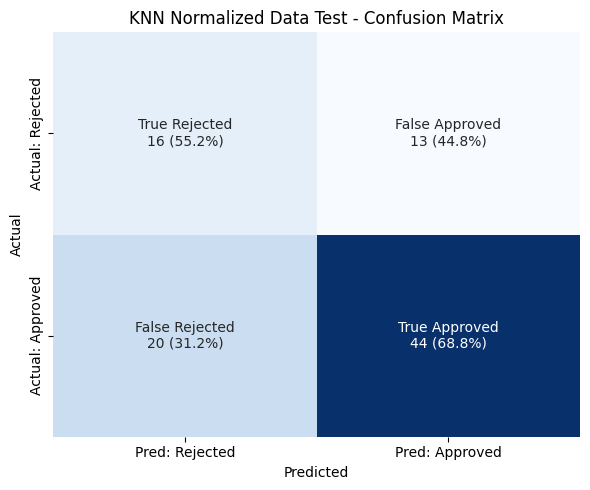


Classification Report:
              precision    recall  f1-score   support

           0      0.444     0.552     0.492        29
           1      0.772     0.688     0.727        64

    accuracy                          0.645        93
   macro avg      0.608     0.620     0.610        93
weighted avg      0.670     0.645     0.654        93


Key Metrics:
- Accuracy: 0.645
- Precision: 0.772
- Rejection Recall: 0.552
- Approval Recall: 0.688
- F1 Score: 0.727
- ROC AUC: 0.697
- PR AUC: 0.820


In [227]:
# Final Test Evaluation
test_model(knn_normalized_model, knn_optimal_thresh_norm, normalized_X_test, y_test, "KNN Normalized Data Test")


ANN Normalized Data Test - Detailed Evaluation

Confusion Matrix (%):
[[65.5 34.5]
 [21.9 78.1]]


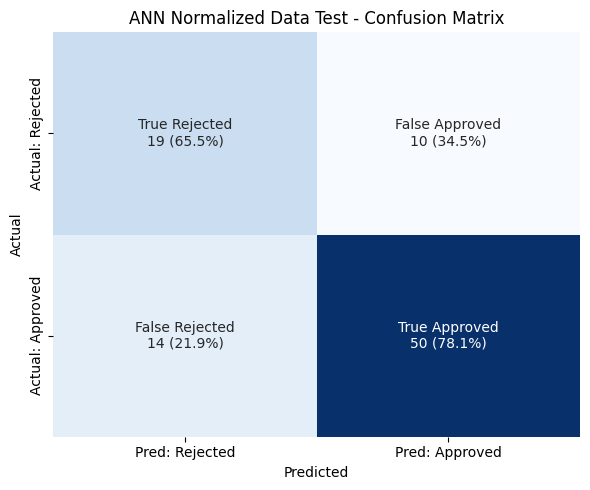


Classification Report:
              precision    recall  f1-score   support

           0      0.576     0.655     0.613        29
           1      0.833     0.781     0.806        64

    accuracy                          0.742        93
   macro avg      0.705     0.718     0.710        93
weighted avg      0.753     0.742     0.746        93


Key Metrics:
- Accuracy: 0.742
- Precision: 0.833
- Rejection Recall: 0.655
- Approval Recall: 0.781
- F1 Score: 0.806
- ROC AUC: 0.770
- PR AUC: 0.841


In [228]:
# Final Test Evaluation
test_model(ann_normalized_model, ann_optimal_thresh_norm, normalized_X_test, y_test, "ANN Normalized Data Test")


Random Forest Normalized Data Test - Detailed Evaluation

Confusion Matrix (%):
[[72.4 27.6]
 [26.6 73.4]]


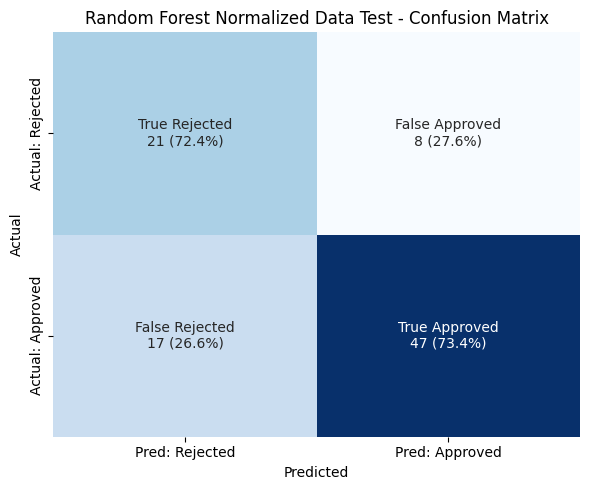


Classification Report:
              precision    recall  f1-score   support

           0      0.553     0.724     0.627        29
           1      0.855     0.734     0.790        64

    accuracy                          0.731        93
   macro avg      0.704     0.729     0.708        93
weighted avg      0.760     0.731     0.739        93


Key Metrics:
- Accuracy: 0.731
- Precision: 0.855
- Rejection Recall: 0.724
- Approval Recall: 0.734
- F1 Score: 0.790
- ROC AUC: 0.775
- PR AUC: 0.858


In [229]:
# Final Test Evaluation
test_model(rf_normalized_model, rf_optimal_thresh_norm, normalized_X_test, y_test, "Random Forest Normalized Data Test")


XGBOOST Normalized Data Test - Detailed Evaluation

Confusion Matrix (%):
[[72.4 27.6]
 [15.6 84.4]]


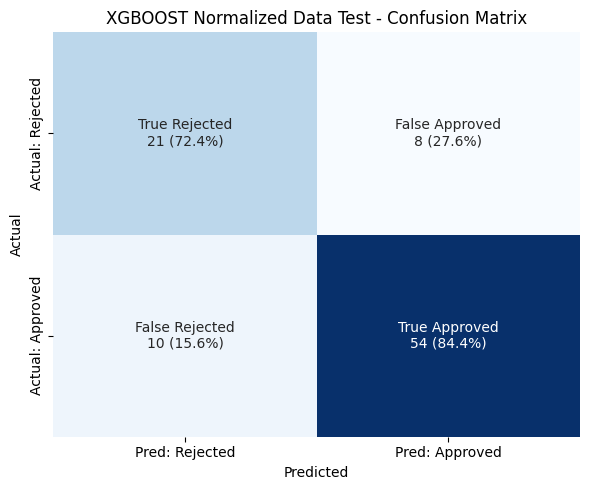


Classification Report:
              precision    recall  f1-score   support

           0      0.677     0.724     0.700        29
           1      0.871     0.844     0.857        64

    accuracy                          0.806        93
   macro avg      0.774     0.784     0.779        93
weighted avg      0.811     0.806     0.808        93


Key Metrics:
- Accuracy: 0.806
- Precision: 0.871
- Rejection Recall: 0.724
- Approval Recall: 0.844
- F1 Score: 0.857
- ROC AUC: 0.786
- PR AUC: 0.848


In [230]:
# Final Test Evaluation
test_model(xgboost_normalized_model, xgboost_optimal_thresh_norm, normalized_X_test, y_test, "XGBOOST Normalized Data Test")

### **Model Performance Comparison Summary**

| Model                  | Accuracy | Rejection Recall | Approval Recall | Precision | F1 Score | ROC AUC | PR AUC |
|------------------------|----------|------------------|-----------------|-----------|----------|---------|--------|
| **Logistic Regression** | 0.806    | 0.655            | **0.875**       | 0.848     | 0.862    | 0.835   | **0.910** |
| **KNN**                | 0.645    | 0.552            | 0.688           | 0.772     | 0.727    | 0.697   | 0.820  |
| **ANN**                | 0.742    | 0.655            | 0.781           | 0.833     | 0.806    | 0.770   | 0.841  |
| **Random Forest**      | 0.731    | **0.724**        | 0.734           | 0.855     | 0.790    | 0.775   | 0.858  |
| **XGBoost**            | **0.806**| **0.724**        | 0.844           | **0.871** | **0.857**| **0.786** | 0.848  |


### **Which Model is Best?**  
**XGBoost** is the **best overall model**, with **Logistic Regression** being a close second for specific use cases. Here's the breakdown:

#### **1. XGBoost (Best Overall)**
✅ **Best Accuracy (80.6%)** – Tied with Logistic Regression  
✅ **Highest Rejection Recall (72.4%)** – Catches the most bad loans  
✅ **Top Precision (87.1%)** – Fewest false approvals  
✅ **Best F1 Score (0.857)** – Excellent balance of precision/recall  
✅ **Strong AUC Scores** – ROC (0.786) and PR (0.848) indicate great ranking  

**Why?**  
- Handles class imbalance better than other models  
- Combines high approval recall (84.4%) with strong risk control  
- More robust to overfitting than ANN/Random Forest  

**Best for:** Most lending scenarios where you want **both high approvals AND strong risk control**.

#### **2. Logistic Regression (Best for Maximizing Approvals)**
✅ **Highest Approval Recall (87.5%)** – Rejects the fewest good applicants  
✅ **Best PR AUC (0.910)** – Excellent precision-recall tradeoff  

**Why runner-up?**  
- Lower rejection recall (65.5% vs XGBoost's 72.4%) means more bad loans slip through  
- Simpler model may not capture complex patterns as well  

**Best for:** Growth-focused lenders who prioritize **customer acquisition over risk control**.

#### **3. Random Forest (Best for Interpretability)**
✅ **High Rejection Recall (72.4%)** – Matches XGBoost  
✅ **Good Precision (85.5%)**  

**Downside:**  
- Lower approval recall (73.4%) hurts customer experience  
- Accuracy (73.1%) lags behind XGBoost/Logistic Regression  

**Best for:** Lenders who need **explainable decisions** (feature importance).

**Bottom Line**: XGBoost provides the **optimal balance**—it catches more bad loans (72.4% vs 65.5%) while maintaining high approvals (84.4% vs 87.5%). The 7% improvement in rejection recall could prevent significant losses with minimal impact on good customers.